# Problem Statement:
Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers. Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.


The main objective here is

    1. What people say about your product: what gives customers’ attitude towards theproduct.
    2. What people do: which reveals what people are doing rather than what they are saying about your product.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

import datetime

from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')
sns.reset_orig()

In [2]:
#load dataset
def load_dataset(path, sep):
    df = pd.read_csv(path, sep=sep)
    pd.set_option('display.max_columns', None)
    return df

In [3]:
path = 'marketing_campaign.csv'
df = load_dataset(path, sep=';')

- Understanding the column names
    - AcceptedCmp1 - 1 if customer accepted the offer in the 1st campaign, 0 otherwise
    - AcceptedCmp2 - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
    - AcceptedCmp3 - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
    - AcceptedCmp4 - 1 if customer accepted the offer in the 4th campaign, 0 otherwise
    - AcceptedCmp5 - 1 if customer accepted the offer in the 5th campaign, 0 otherwise
    - Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise
    - Complain - 1 if customer complained in the last 2 years
    - DtCustomer - date of customer’s enrolment with the company
    - Education - customer’s level of education
    - Marital - customer’s marital status
    - Kidhome - number of small children in customer’s household
    - Teenhome - number of teenagers in customer’s household
    - Income - customer’s yearly household income
    - MntFishProducts - amount spent on fish products in the last 2 years
    - MntMeatProducts - amount spent on meat products in the last 2 years
    - MntFruits - amount spent on fruits products in the last 2 years
    - MntSweetProducts - amount spent on sweet products in the last 2 years
    - MntWines - amount spent on wine products in the last 2 years
    - MntGoldProds - amount spent on gold products in the last 2 years
    - NumDealsPurchases - number of purchases made with discount
    - NumCatalogPurchases - number of purchases made using catalogue
    - NumStorePurchases - number of purchases made directly in stores
    - NumWebPurchases - number of purchases made through company’s web site
    - NumWebVisitsMonth - number of visits to company’s web site in the last month
    - Recency - number of days since the last purchase

In [4]:
df

ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      5524        1957  Graduation         Single  58138.0        0   
1      2174        1954  Graduation         Single  46344.0        1   
2      4141        1965  Graduation       Together  71613.0        0   
3      6182        1984  Graduation       Together  26646.0        1   
4      5324        1981         PhD        Married  58293.0        1   
...     ...         ...         ...            ...      ...      ...   
2235  10870        1967  Graduation        Married  61223.0        0   
2236   4001        1946         PhD       Together  64014.0        2   
2237   7270        1981  Graduation       Divorced  56981.0        0   
2238   8235        1956      Master       Together  69245.0        0   
2239   9405        1954         PhD        Married  52869.0        1   

      Teenhome Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  \
0            0  2012-09-04       58       635         88              546   
1            1  2014-03-08       38        11          1                6   
2            0  2013-08-21       26       426         49              127   
3            0  2014-02-10       26        11          4               20   
4            0  2014-01-19       94       173         43              118   
...        ...         ...      ...       ...        ...              ...   
2235         1  2013-06-13       46       709         43              182   
2236         1  2014-06-10       56       406          0               30   
2237         0  2014-01-25       91       908         48              217   
2238         1  2014-01-24        8       428         30              214   
2239         1  2012-10-15       40        84          3               61   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
0                 172                88            88                  3   
1                   2                 1             6                  2   
2                 111                21            42                  1   
3                  10                 3             5                  2   
4                  46                27            15                  5   
...               ...               ...           ...                ...   
2235               42               118           247                  2   
2236                0                 0             8                  7   
2237               32                12            24                  1   
2238               80                30            61                  2   
2239                2                 1            21                  3   

      NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
0                   8                   10                  4   
1                   1                    1                  2   
2                   8                    2                 10   
3                   2                    0                  4   
4                   5                    3                  6   
...               ...                  ...                ...   
2235                9                    3                  4   
2236                8                    2                  5   
2237                2                    3                 13   
2238                6                    5                 10   
2239                3                    1                  4   

      NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
0                     7             0             0             0   
1                     5             0             0             0   
2                     4             0             0             0   
3                     6             0             0             0   
4                     5             0             0             0   
...                 ...           ...           ...           ...   
2235                  5             0     

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
null = df['Income'].isnull()

In [7]:
null.sum()

24

In [8]:
#function that check null values
def null_values(data):
    for i in data.columns:
        null = data[i].isnull().sum()
        if null>0:
            print("'{}' feature contains {} null values accounting for {:.2f}%".format(i,null,(null/len(data))*100))

In [9]:
null_values(df)

'Income' feature contains 24 null values accounting for 1.07%


In [10]:
24/len(df)

0.010714285714285714

In [11]:
df.duplicated().sum()

0

In [12]:
df.describe().T

count          mean           std     min       25%  \
ID                   2240.0   5592.159821   3246.662198     0.0   2828.25   
Year_Birth           2240.0   1968.805804     11.984069  1893.0   1959.00   
Income               2216.0  52247.251354  25173.076661  1730.0  35303.00   
Kidhome              2240.0      0.444196      0.538398     0.0      0.00   
Teenhome             2240.0      0.506250      0.544538     0.0      0.00   
Recency              2240.0     49.109375     28.962453     0.0     24.00   
MntWines             2240.0    303.935714    336.597393     0.0     23.75   
MntFruits            2240.0     26.302232     39.773434     0.0      1.00   
MntMeatProducts      2240.0    166.950000    225.715373     0.0     16.00   
MntFishProducts      2240.0     37.525446     54.628979     0.0      3.00   
MntSweetProducts     2240.0     27.062946     41.280498     0.0      1.00   
MntGoldProds         2240.0     44.021875     52.167439     0.0      9.00   
NumDealsPurchases    2240.0      2.325000      1.932238     0.0      1.00   
NumWebPurchases      2240.0      4.084821      2.778714     0.0      2.00   
NumCatalogPurchases  2240.0      2.662054      2.923101     0.0      0.00   
NumStorePurchases    2240.0      5.790179      3.250958     0.0      3.00   
NumWebVisitsMonth    2240.0      5.316518      2.426645     0.0      3.00   
AcceptedCmp3         2240.0      0.072768      0.259813     0.0      0.00   
AcceptedCmp4         2240.0      0.074554      0.262728     0.0      0.00   
AcceptedCmp5         2240.0      0.072768      0.259813     0.0      0.00   
AcceptedCmp1         2240.0      0.064286      0.245316     0.0      0.00   
AcceptedCmp2         2240.0      0.013393      0.114976     0.0      0.00   
Complain             2240.0      0.009375      0.096391     0.0      0.00   
Z_CostContact        2240.0      3.000000      0.000000     3.0      3.00   
Z_Revenue            2240.0     11.000000      0.000000    11.0     11.00   
Response             2240.0      0.149107      0.356274     0.0      0.00   

                         50%       75%       max  
ID                    5458.5   8427.75   11191.0  
Year_Birth            1970.0   1977.00    1996.0  
Income               51381.5  68522.00  666666.0  
Kidhome                  0.0      1.00       2.0  
Teenhome                 0.0      1.00       2.0  
Recency                 49.0     74.00      99.0  
MntWines               173.5    504.25    1493.0  
MntFruits                8.0     33.00     199.0  
MntMeatProducts         67.0    232.00    1725.0  
MntFishProducts         12.0     50.00     259.0  
MntSweetProducts         8.0     33.00     263.0  
MntGoldProds            24.0     56.00     362.0  
NumDealsPurchases        2.0      3.00      15.0  
NumWebPurchases          4.0      6.00      27.0  
NumCatalogPurchases      2.0      4.00      28.0  
NumStorePurchases        5.0      8.00      13.0  
NumWebVisitsMonth        6.0      7.00      20.0  
AcceptedCmp3             0.0      0.00       1.0  
AcceptedCmp4             0.0      0.00       1.0  
AcceptedCmp5             0.0      0.00       1.0  
AcceptedCmp1             0.0      0.00       1.0  
AcceptedCmp2             0.0      0.00       1.0  
Complain                 0.0      0.00       1.0  
Z_CostContact            3.0      3.00       3.0  
Z_Revenue               11.0     11.00      11.0  
Response                 0.0      0.00       1.0

In [13]:
df.describe(include='object')

Education Marital_Status Dt_Customer
count         2240           2240        2240
unique           5              8         663
top     Graduation        Married  2012-08-31
freq          1127            864          12

In [14]:
df.select_dtypes(include=['int64', 'float64']).nunique()

ID                     2240
Year_Birth               59
Income                 1974
Kidhome                   3
Teenhome                  3
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntGoldProds            213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

In [15]:
df.select_dtypes(include='object').nunique()

Education           5
Marital_Status      8
Dt_Customer       663
dtype: int64

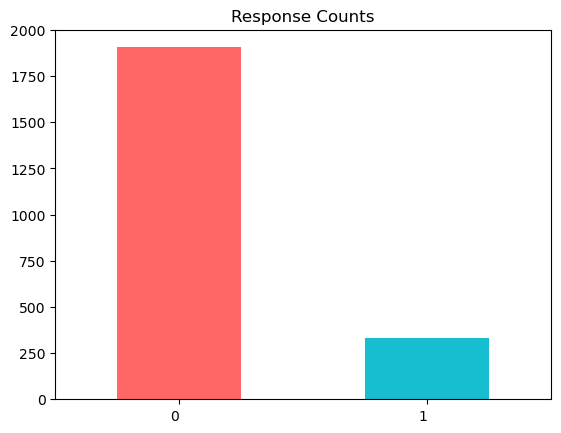

In [16]:
ax = df['Response'].value_counts().plot(kind='bar', color=['#ff6666', '#17becf'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')
ax.set_title('Response Counts')
plt.show()

In [17]:
#calculate age using year
current_year = datetime.date.today().year
df['age'] = df['Year_Birth'].apply(lambda year:current_year-year)

In [18]:
df.drop(['Year_Birth'], axis=1, inplace=True)

In [19]:
#function that create variables with features based on the dtypes
def dtypes(df):
    num_features = df.drop('ID', axis=1).select_dtypes(include = ['int64', 'float64'])
    cat_features = df.select_dtypes(exclude = ['int64', 'float64'])
    return num_features.columns, cat_features.columns

num_features, cat_features = dtypes(df)

In [20]:
print('Numerical features in the dataset are: ',num_features,
      '\nCategorical features in the dataset are: ',cat_features, sep='\n')

Numerical features in the dataset are: 
Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'age'],
      dtype='object')

Categorical features in the dataset are: 
Index(['Education', 'Marital_Status', 'Dt_Customer'], dtype='object')


In [21]:
#function to check the features with zero variance
def zero_var_features(data=None, features=None):
    for feature in features:
        var = data[feature].var()
        if var==0:
            data.drop(feature, axis=1, inplace=True)

zero_var_features(data=df, features=num_features)

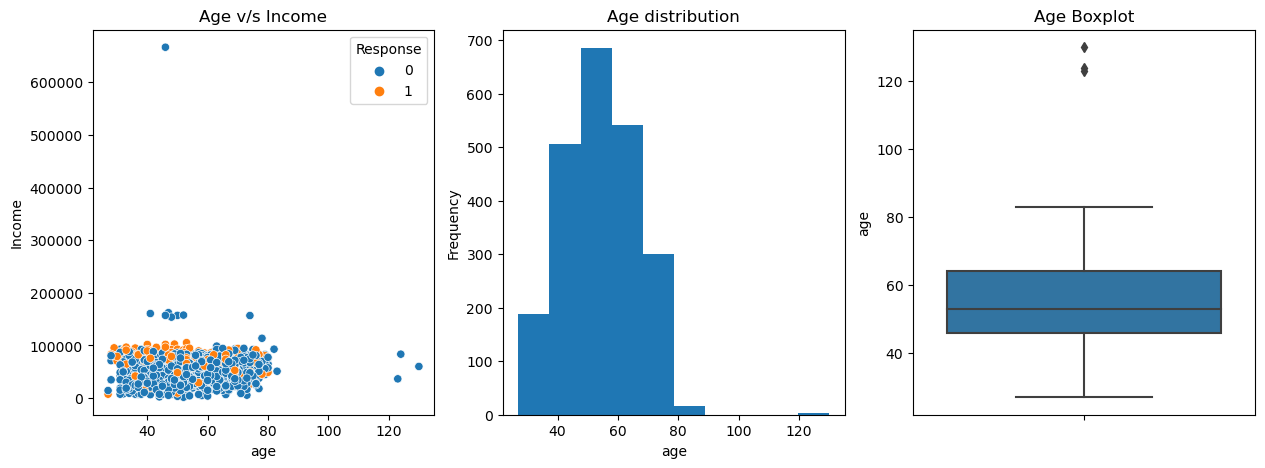

In [22]:
plt.subplots(figsize=(15,5))
plt.subplot(1,3,1)
sns.scatterplot(x='age', y='Income', data=df, hue='Response')
plt.title('Age v/s Income')
plt.subplot(1,3,2)
plt.hist(x = df['age'])
plt.xlabel('age')
plt.title('Age distribution')
plt.ylabel('Frequency')
plt.subplot(1,3,3)
sns.boxplot(y='age', data=df)
plt.title('Age Boxplot')
plt.show()

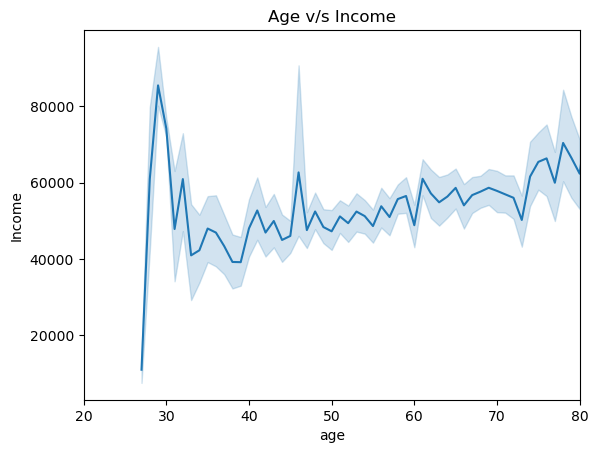

In [23]:
sns.lineplot(df, x='age', y='Income')
plt.xlim(20,80)
plt.title('Age v/s Income')
plt.show()

- We can observe from the above plots that we have some outliers in both in the 'age' and 'Income' columns

In [24]:
# Filter DataFrame for Response == 1
filtered_df = df[df['Response'] == 1]

# Calculate response count by Marital Status
marital_response = pd.DataFrame(filtered_df.groupby('Marital_Status')['Response'].count())
marital_response.reset_index(inplace=True)

# Calculate overall Marital Status count
marital_count = pd.DataFrame(df.groupby('Marital_Status')['Response'].count())
marital_count.reset_index(inplace=True)

accept_percentage = pd.merge(marital_count, marital_response, on='Marital_Status')
accept_percentage = accept_percentage.rename(columns={'Response_x':'Total_count', 'Response_y':'Accepted'})
accept_percentage['Accepted_percentage'] = (round(accept_percentage['Accepted']/accept_percentage['Total_count'],2)*100)
#display(accept_percentage)

# Create subplots
fig = sp.make_subplots(
    rows=1, 
    cols=3, 
    subplot_titles=('Marital Status count','Response (campaign accepted)<br>count by Marital Status','Accepted Percentage'))

# Plot 1 - Response Count
fig.add_trace(
    go.Bar(
        x=marital_count['Marital_Status'], 
        y=marital_count['Response'], 
        name='Count'), 
    row=1,
    col=1
)

# Plot 2 - Marital Status Count
fig.add_trace(
    go.Bar(
        x=marital_response['Marital_Status'],
        y=marital_response['Response'],
        name='Response'),
    row=1,
    col=2
)

# PLot 3 - Accept Percentage
fig.add_trace(
    go.Bar(
        x=accept_percentage['Marital_Status'],
        y=accept_percentage['Accepted_percentage'],
        name='Accept Percentage'),
    row=1,
    col=3
)

# Update layout
fig.update_layout(showlegend=False)

#change the font size of the titles
for plot_num in range(3):
    fig.layout['annotations'][plot_num]['font']['size'] = 13
    
# Set labels for x and y axes
axes_labels = [
    ('Marital Status', 'Total Count'), 
    ('Marital Status', 'Response Count'), 
    ('Marital Status', 'Accepted Percentage')
]

for i, (x_label, y_label) in enumerate(axes_labels, 1):
    fig.update_xaxes(title_text=x_label, row=1, col=i)
    fig.update_yaxes(title_text=y_label, row=1, col=i, title_standoff=1)
    
# Show the plot
fig.show()

- We can observe that more 'Widow','Single' accepted the offer in the last campaign

In [25]:
si = SimpleImputer(strategy='mean')
df['Income'] = si.fit_transform(df[['Income']])

In [26]:
fig = px.scatter(df, x='Recency', y='Income', color='Response', title='Response for Recency v/s Income',
                marginal_x='histogram', width=800, height=500)
fig.show()

In [27]:
bins = [-1, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']

df['Recency_group'] = pd.cut(df['Recency'], bins=bins, labels=labels)

recency_responce = pd.DataFrame(df.groupby(['Recency_group','Response']).size(), columns=['Count'])
recency_responce.reset_index(inplace=True)

fig = px.bar(
    data_frame = recency_responce,
    x = 'Recency_group', 
    y = 'Count', 
    color = 'Response',
    title = 'Distribution based on the Recency Group'
)

fig.update_coloraxes(colorscale=[[0, '#ff6666'], [1, '#17becf']])

fig.update_layout(
    xaxis_title='Recency Group',
    yaxis_title='Count'
)

fig.show()

- From the above plot we can see that as the Recency increases the chances of accepting reduces

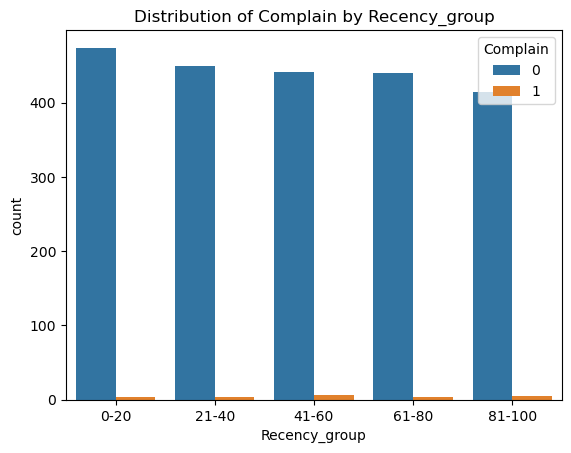

In [28]:
sns.countplot(data=df, x='Recency_group', hue='Complain')
plt.title('Distribution of Complain by Recency_group')
plt.show()

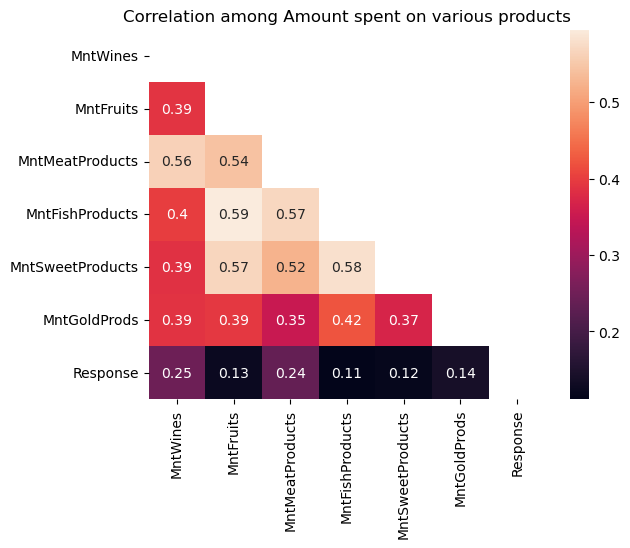

In [29]:
df_product_spend = df[['MntWines', 'MntFruits', 'MntMeatProducts', 
            'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Response']]
mask = np.triu(df_product_spend.corr())
sns.heatmap(df_product_spend.corr(), annot=True, mask=mask)
plt.title('Correlation among Amount spent on various products')
plt.show()

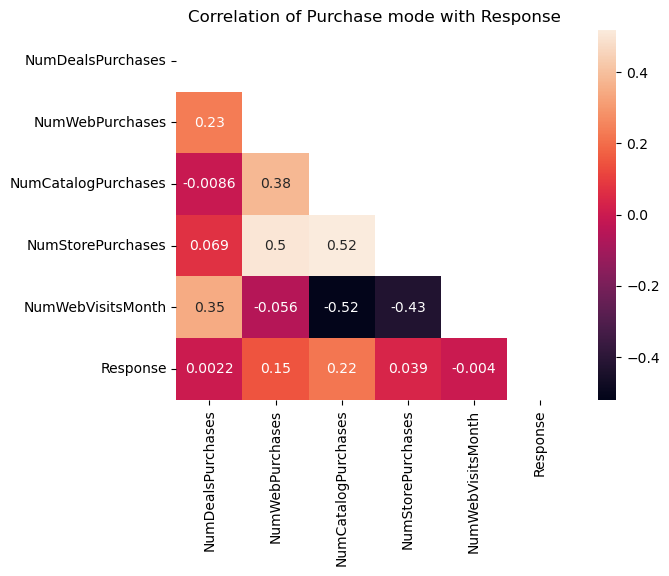

In [30]:
df_purchase = df[['NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases', 
                'NumStorePurchases', 'NumWebVisitsMonth', 'Response']]
mask = np.triu(df_purchase.corr())
sns.heatmap(df_purchase.corr(), annot=True, mask=mask)
plt.title('Correlation of Purchase mode with Response')
plt.show()

- People who purchase more from Catalogue tend to have more Response to the campaign compared to others

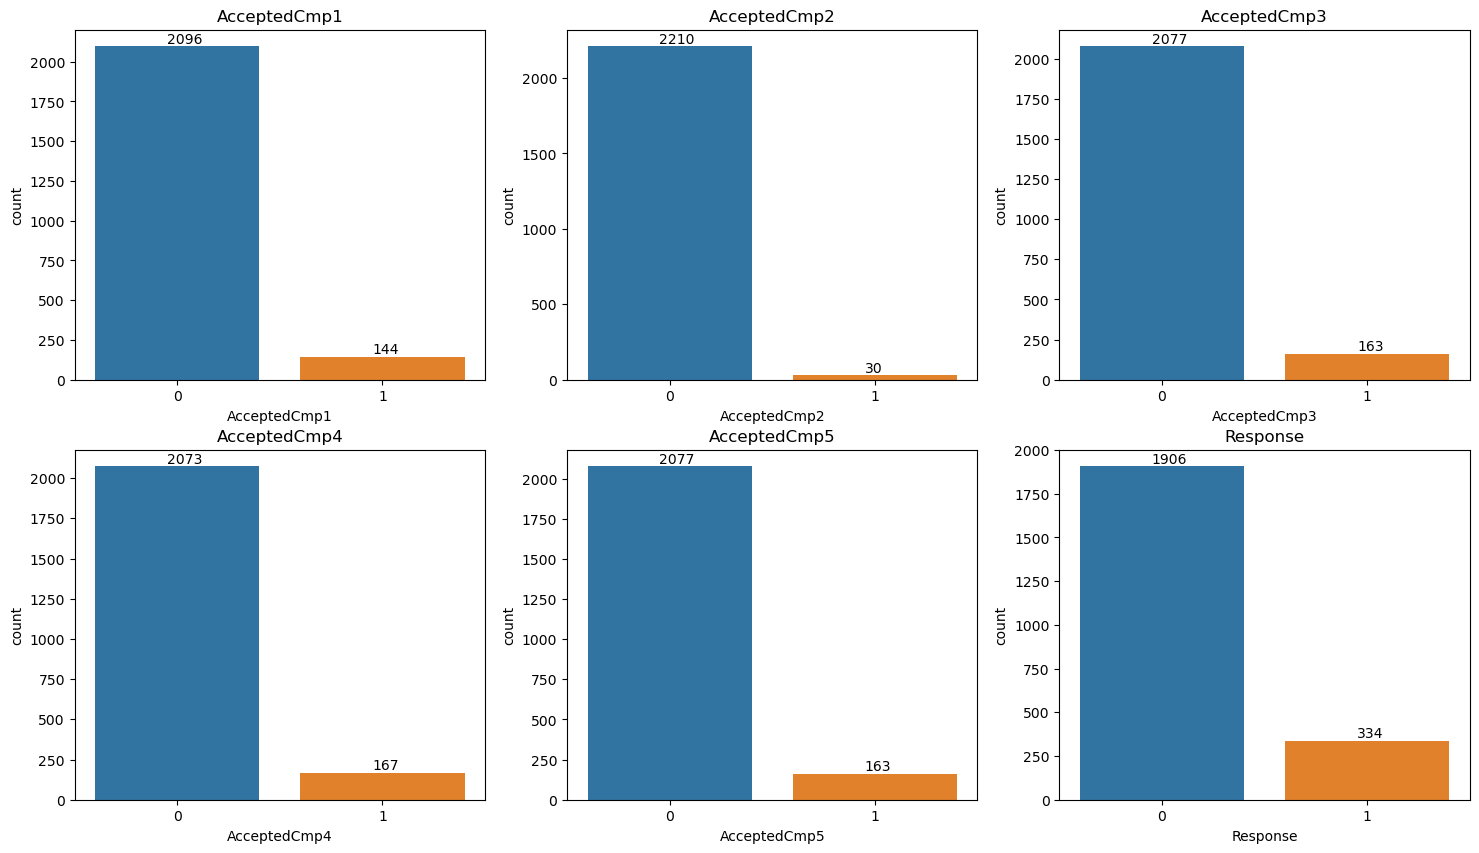

In [31]:
campaigns = ['AcceptedCmp1', 'AcceptedCmp2','AcceptedCmp3','AcceptedCmp4', 'AcceptedCmp5', 'Response']
plt.figure(figsize=(18,10))
for i, camp in enumerate(campaigns):
    ax = plt.subplot(2,3,i+1)
    ax = sns.countplot(df, x=camp)
    for i in ax.patches:
        ax.annotate('{:.0f}'.format(i.get_height()), (i.get_x()+0.35, i.get_height()+20))
    plt.title(camp)
    
plt.show()

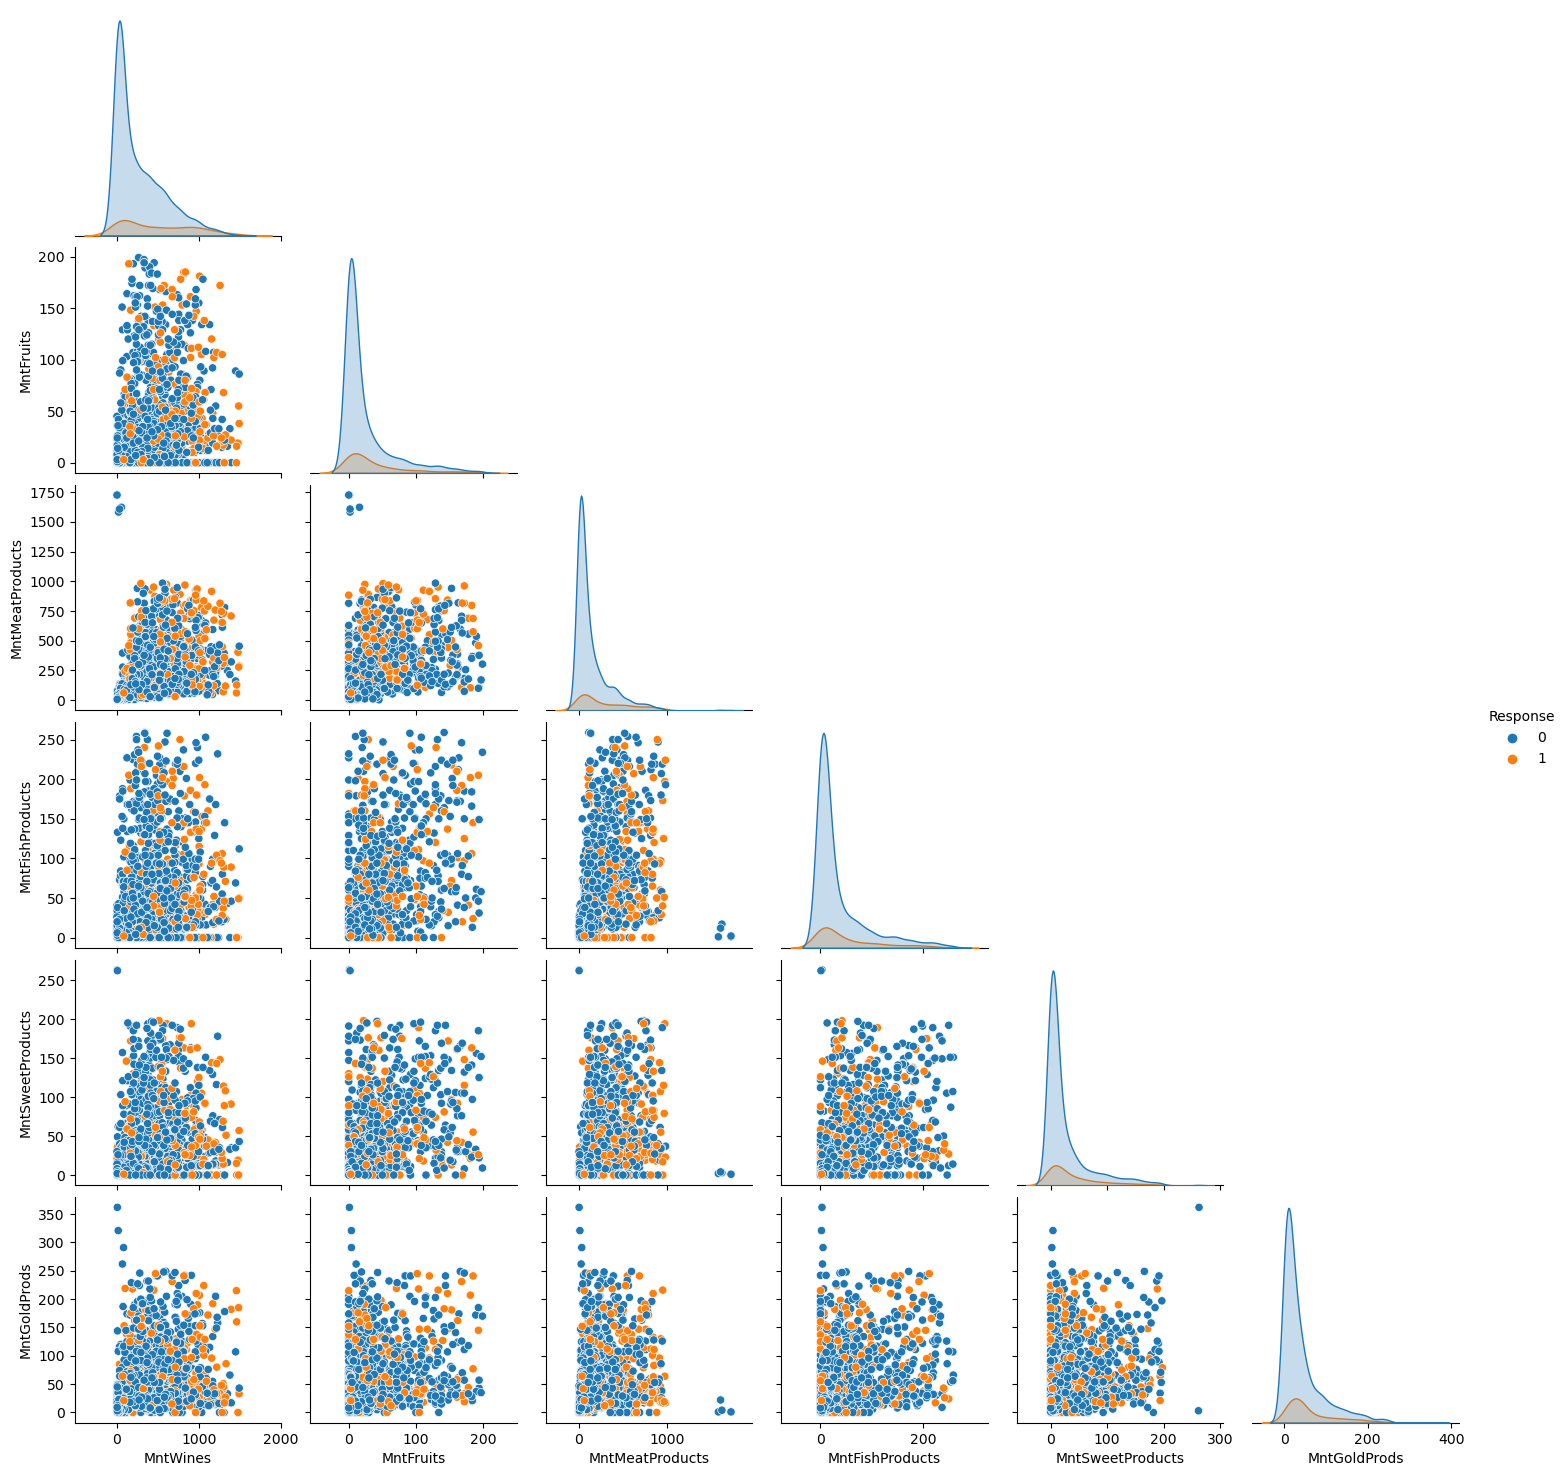

In [32]:
products = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_subset = df[products + ['Response']]

# Create pair plot
sns.pairplot(df_subset, hue='Response', corner=True)

plt.show()

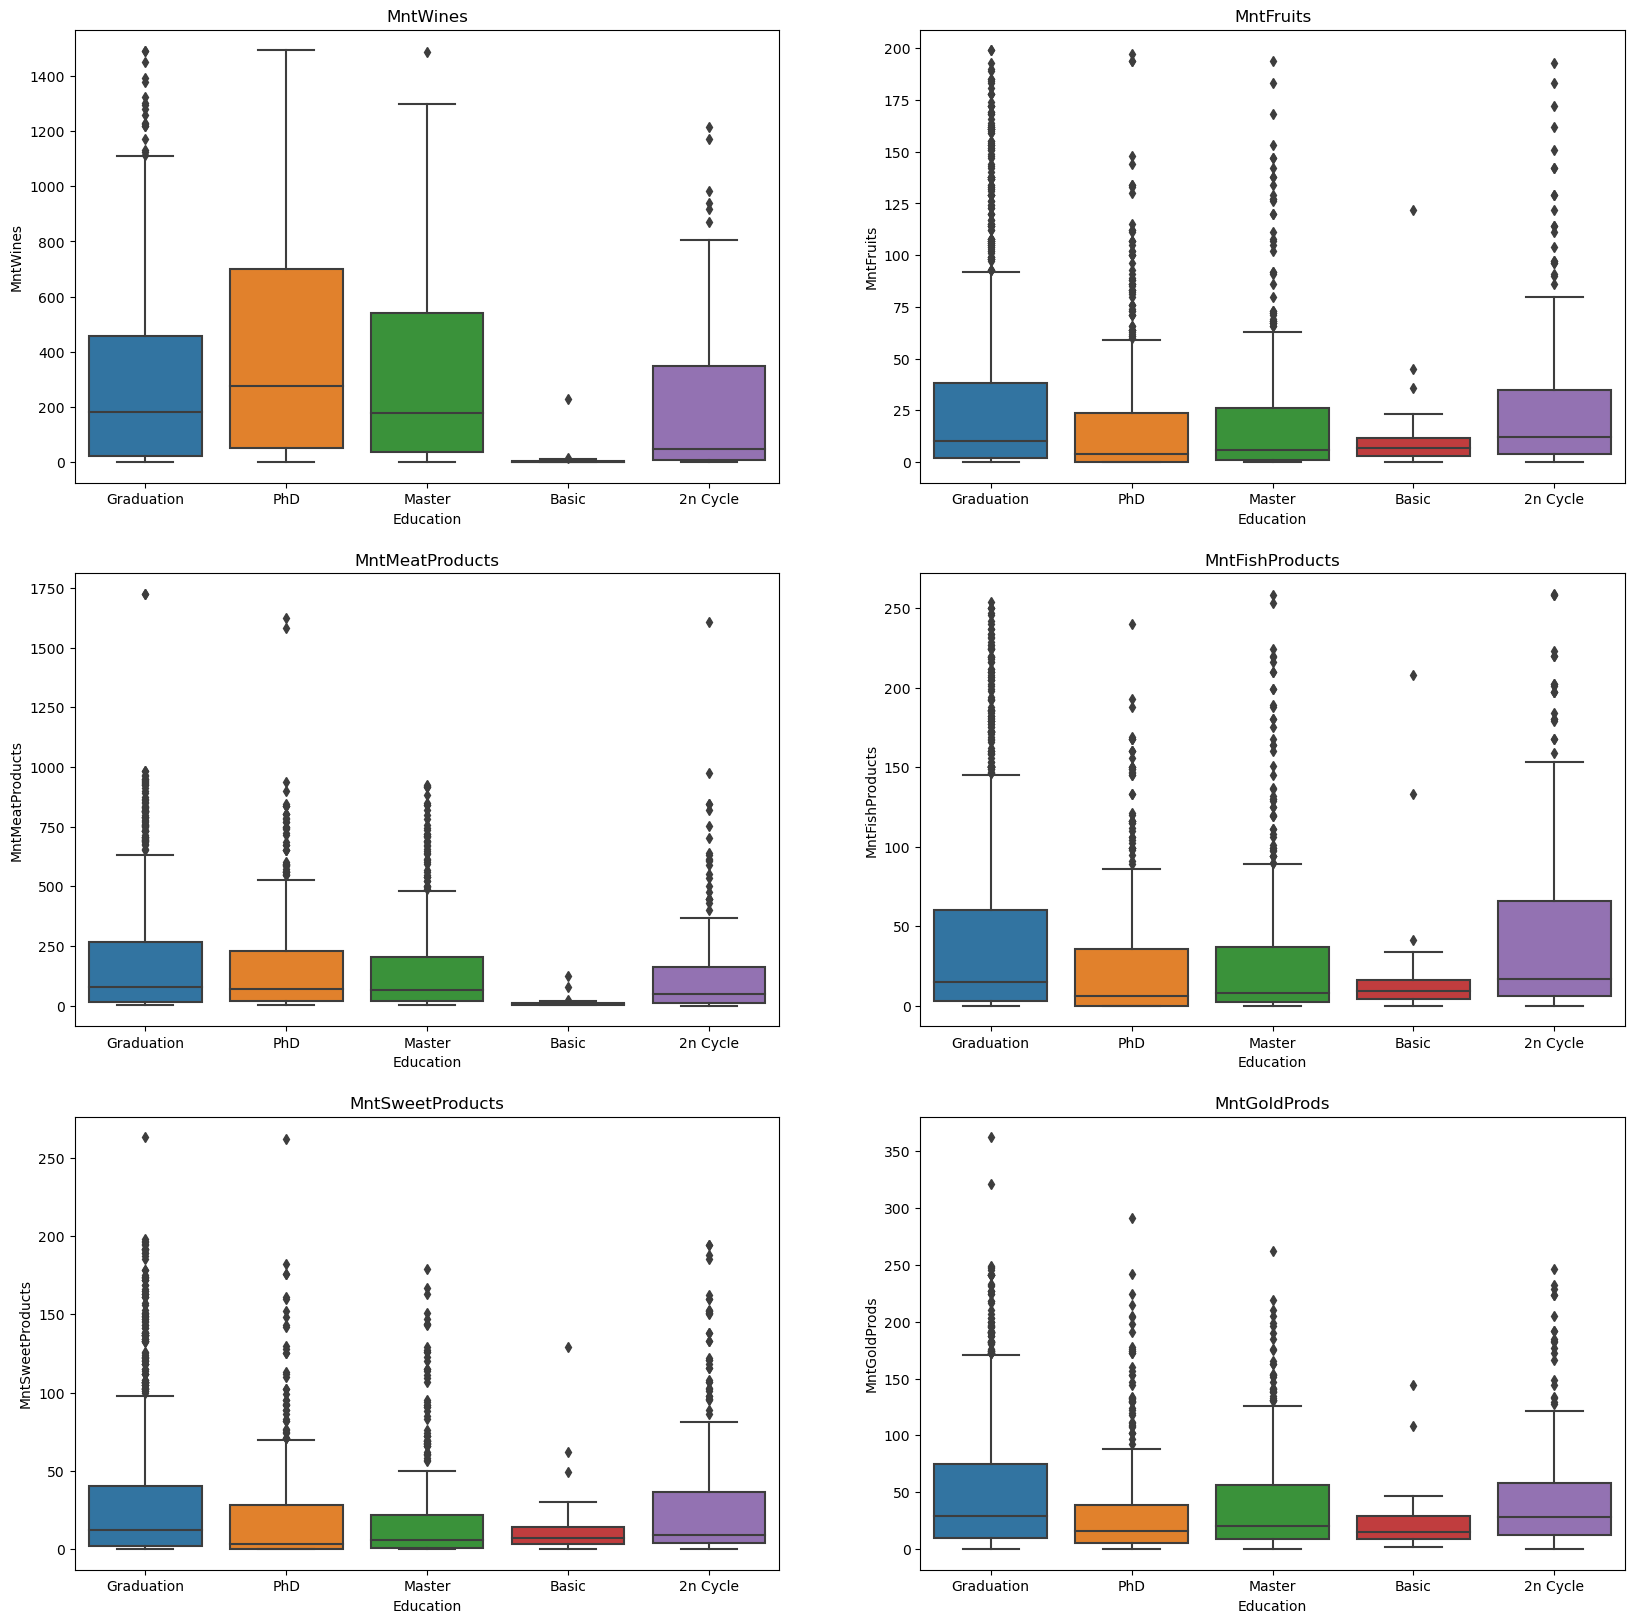

In [33]:
plt.figure(figsize=(20,20))
for i, prod in enumerate(products, 1):
    plt.subplot(3,2,i)
    sns.boxplot(df, x='Education', y=prod)
    plt.title(prod)
    
plt.show()

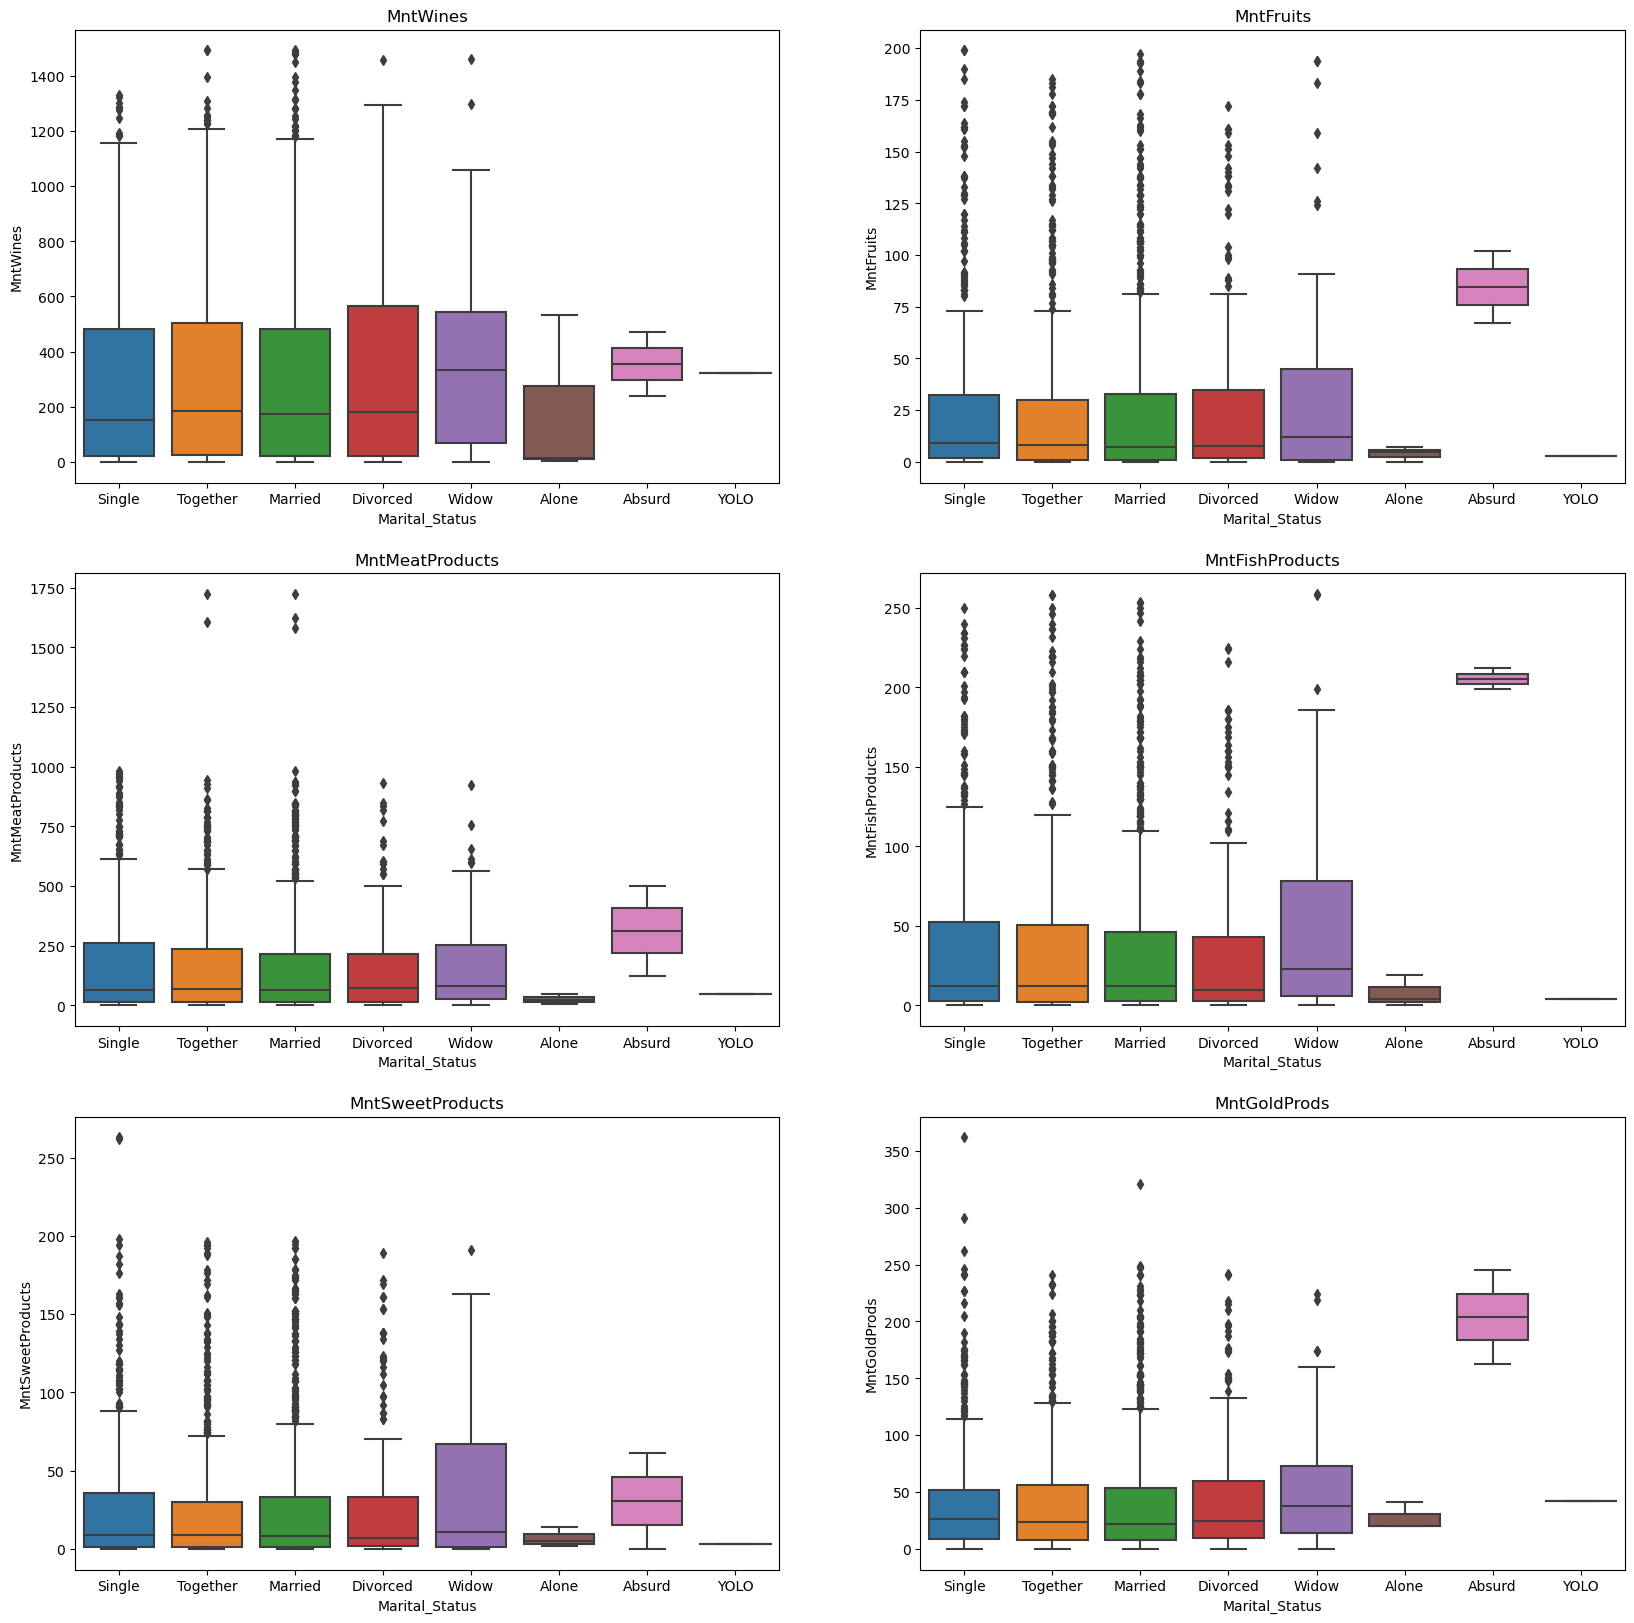

In [34]:
plt.figure(figsize=(20,20))
for i, prod in enumerate(products, 1):
    plt.subplot(3,2,i)
    sns.boxplot(df, x='Marital_Status', y=prod)
    plt.title(prod)
    
plt.show()

In [35]:
df['Total_spend'] = df[products].sum(axis=1)

df.drop(['MntWines', 'MntFruits', 'MntMeatProducts', 
        'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'], axis=1, inplace=True)

In [36]:
education_df = pd.DataFrame(df.groupby('Education')['Total_spend', 'Income'].mean())
education_df['Count'] = df.groupby('Education')['Response'].size()
education_df['Final_campaign_accepted'] = filtered_df.groupby('Education')['Response'].size()
education_df.reset_index(inplace=True)
#display(education_df)

fig = sp.make_subplots(
    rows=2, 
    cols=2,
    subplot_titles=['Education Count', 'Final Campaign Acceptance based on Education',
                   'Average Spend based on Education', 'Average Income based on Education'])

var = [
    ('Education', 'Count'),
    ('Education', 'Final_campaign_accepted'),
    ('Education','Total_spend'),
    ('Education', 'Income')]

traces = []
for i,(x,y) in enumerate(var): 
    trace = px.bar(data_frame=education_df, x=x, y=y)
    traces.append(trace)

traces[0].data[0].marker.color = None
traces[1].data[0].marker.color = 'green'
traces[2].data[0].marker.color = 'RebeccaPurple'
traces[3].data[0].marker.color = 'orange'

fig.add_trace(traces[0].data[0], row=1, col=1)
fig.add_trace(traces[1].data[0], row=1, col=2)
fig.add_trace(traces[2].data[0], row=2, col=1)
fig.add_trace(traces[3].data[0], row=2, col=2)

row1_labels = [
    ('Education', 'Count'),
    ('Education', 'Response Count')]
row2_labels = [
    ('Education','Average Spend'),
    ('Education', 'Average Income')]

for i, (x,y) in enumerate(row1_labels,1):
    fig.update_xaxes(title_text=x, row=1, col=i)
    fig.update_yaxes(title_text=y, row=1, col=i, title_standoff=1)
for i, (x,y) in enumerate(row2_labels,1):
    fig.update_xaxes(title_text=x, row=2, col=i)
    fig.update_yaxes(title_text=y, row=2, col=i, title_standoff=1)

fig.update_layout(height=600, width=800, showlegend=False)
fig.show()


fig = px.scatter(data_frame=df, x='Income', y='Total_spend', color='Response',
                title="Relationship between Income and Total Spend (Colored by Response)")
fig.show()

- From the plots we can observe that Income and Total_spend is positively correlated

In [37]:
interval = [15,30,60,90]

#the length of categories should be equal to the number of intervals
categories = ['yound_adult', 'middle-age', 'senior_citizen']

df['age_category'] = pd.cut(df['age'], bins=interval, labels=categories)
age_responce = pd.DataFrame(df.groupby(['age_category','Response']).size(), columns=['Count'])
age_responce.reset_index(inplace=True)

fig = sp.make_subplots(
    rows=1,
    cols=2,
    subplot_titles=['Response Count by Age Category',
                    "Relationship between Age and<br>Total Spend (Colored by Response)"])

trace1 = px.bar(
    data_frame = age_responce,
    x = 'age_category', 
    y = 'Count', 
    color = 'Response',
    height=500, 
    width=700,
    title = 'Response Count by Age Category')

trace2 = px.scatter(data_frame=df, x='age', y='Total_spend', color='Response', height=500, width=700)

fig.add_trace(trace1.data[0], row=1, col=1)
fig.add_trace(trace2.data[0], row=1, col=2)

labels = [('Age', 'Response Count'), ('Age', 'Total Spend')]
for i, (x,y) in enumerate(labels,1):
    fig.update_xaxes(title_text=x, row=1, col=i)
    fig.update_yaxes(title_text=y, row=1, col=i, title_standoff=1)

fig.show()

In [38]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Yr_joined'] = df['Dt_Customer'].dt.year

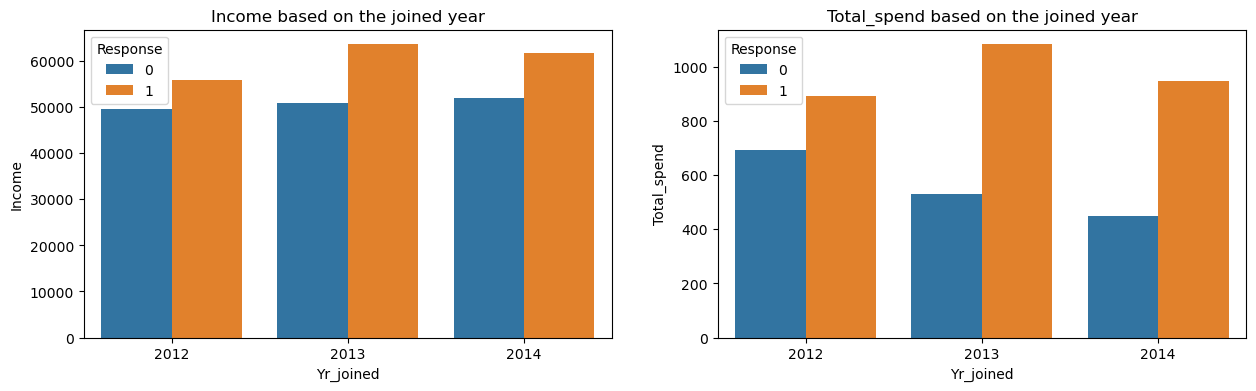

In [39]:
enrolment_yr = df.groupby(['Yr_joined','Response'])['Income', 'Total_spend'].mean()
enrolment_yr.reset_index(inplace=True)
#display(enrolment_yr)

cols = ['Income', 'Total_spend']
plt.subplots(figsize=(15,4))
plot = 1
for i in cols:
    plt.subplot(1,2,plot)
    sns.barplot(data=enrolment_yr, x='Yr_joined', y=i, hue='Response')
    plt.title('{i} based on the joined year'.format(i=i))
    plot+=1
plt.show()

In [40]:
fig = sp.make_subplots(
    rows=1,
    cols=2,
    subplot_titles=['Income based on the year joined','Total Spend based on the year joined'])

trace1 = px.bar(
    data_frame = enrolment_yr,
    x = 'Yr_joined', 
    y = 'Income', 
    color = 'Response',
    height=500, 
    width=700)

trace2 = px.bar(data_frame=enrolment_yr, x='Yr_joined', y='Total_spend', color='Response', height=500, width=700)

fig.add_trace(trace1.data[0], row=1, col=1)
fig.add_trace(trace2.data[0], row=1, col=2)

labels = [('Year Joined', 'Income'), ('Year Joined', 'Total Spend')]
for i, (x,y) in enumerate(labels,1):
    fig.update_xaxes(title_text=x, row=1, col=i)
    fig.update_yaxes(title_text=y, row=1, col=i, title_standoff=1)
    
fig.update_layout(showlegend=True)

fig.show()

- The longer the relationship of the customer with the company the more they spend and the greater is the chance they accept the offer

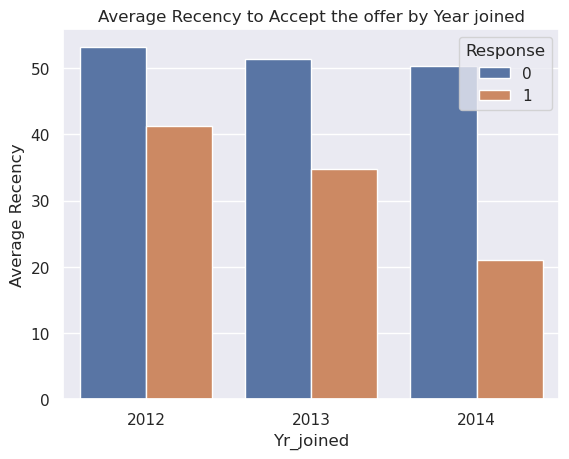

In [41]:
recency_response = pd.DataFrame(df.groupby(['Yr_joined','Response'])['Recency'].mean())
recency_response.reset_index(inplace=True)
display(recency_response.style.background_gradient(cmap='Blues', subset='Recency'))

sns.set(font='sans-serif')

sns.barplot(data=recency_response, x='Yr_joined', y='Recency', hue='Response')
plt.ylabel('Average Recency')
plt.title('Average Recency to Accept the offer by Year joined')
plt.show()

- Customers who have longer relation ship with the company can accept the offer with higher recency compared to the customer joined later
- For the customers who joined in 2014 if the customer had purchases any product in the last 20 days (on an average) has higher chance of accepting the offer than the ones with longer period

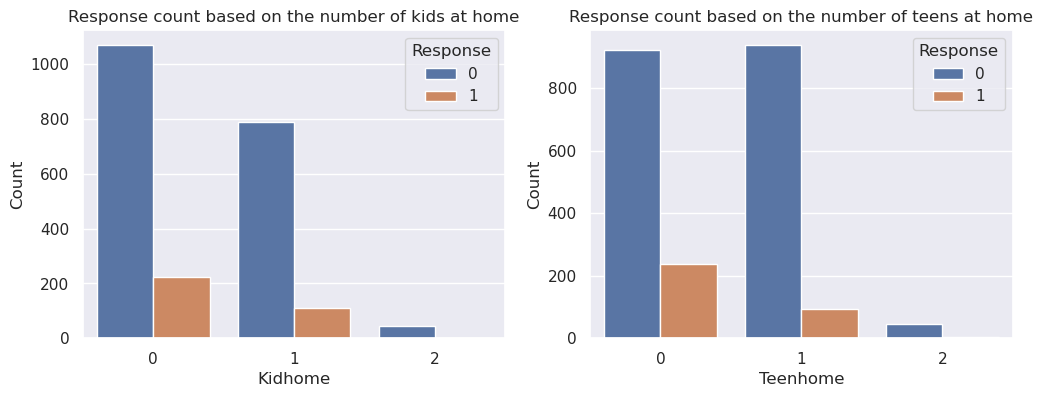

In [42]:
kidhome_response = pd.DataFrame(df.groupby(['Kidhome','Response']).size(), columns=['Count'])
kidhome_response.reset_index(inplace=True)

teenhome_response = pd.DataFrame(df.groupby(['Teenhome','Response']).size(), columns=['Count'])
teenhome_response.reset_index(inplace=True)

#display(kidhome_response, teenhome_response)

plt.subplots(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(data=kidhome_response, x='Kidhome', y='Count', hue='Response')
plt.title('Response count based on the number of kids at home')

plt.subplot(1,2,2)
sns.barplot(data=teenhome_response, x='Teenhome', y='Count', hue='Response')
plt.title('Response count based on the number of teens at home')

plt.show()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2240 non-null   int64         
 1   Education            2240 non-null   object        
 2   Marital_Status       2240 non-null   object        
 3   Income               2240 non-null   float64       
 4   Kidhome              2240 non-null   int64         
 5   Teenhome             2240 non-null   int64         
 6   Dt_Customer          2240 non-null   datetime64[ns]
 7   Recency              2240 non-null   int64         
 8   NumDealsPurchases    2240 non-null   int64         
 9   NumWebPurchases      2240 non-null   int64         
 10  NumCatalogPurchases  2240 non-null   int64         
 11  NumStorePurchases    2240 non-null   int64         
 12  NumWebVisitsMonth    2240 non-null   int64         
 13  AcceptedCmp3         2240 non-nul

In [44]:
features = ['Income', 'age', 'Total_spend', 'Recency']
def outliers(df, features):
    for col in features:
        df_sorted = df[col].sort_values()
        q25, q75 = np.percentile(df_sorted, [25, 75])
        iqr = q75 - q25
        lower = q25 - 1.5 * iqr
        upper = q75 + 1.5 * iqr
        
        outliers = df[(df[col] > upper) | (df[col] < lower)][col]
        
        if len(outliers) > 0:
            print(f"\n-----> '{col}' outlier points:")
            print(outliers)
            print('Upper Limit: {}, Lower Limit: {}'.format(upper, lower))
        else:
            print("\n-----> '{}' has no outliers".format(col))
        
        df.loc[df[col] < lower, col] = np.percentile(df[col], 10)
        df.loc[df[col] > upper, col] = np.percentile(df[col], 90)

outliers(df, features)



-----> 'Income' outlier points:
164     157243.0
617     162397.0
655     153924.0
687     160803.0
1300    157733.0
1653    157146.0
2132    156924.0
2233    666666.0
Name: Income, dtype: float64
Upper Limit: 117416.25, Lower Limit: -13587.75

-----> 'age' outlier points:
192    123
239    130
339    124
Name: age, dtype: int64
Upper Limit: 91.0, Lower Limit: 19.0

-----> 'Total_spend' outlier points:
1179    2525
1492    2524
1572    2525
Name: Total_spend, dtype: int64
Upper Limit: 2510.625, Lower Limit: -1396.375

-----> 'Recency' has no outliers


In [45]:
outliers(df, features)


-----> 'Income' has no outliers

-----> 'age' has no outliers

-----> 'Total_spend' has no outliers

-----> 'Recency' has no outliers


In [46]:
#children size
#df['Children'] = df['Kidhome'] + df['Teenhome']
#df.drop(['Kidhome','Teenhome'], axis=1, inplace=True)

In [47]:
le = LabelEncoder()

In [48]:
def encode_marital_status(df, feature):
    living_with_mapping = {'Married': 'Partner', 'Together': 'Partner', 'Absurd': 'Alone',
                           'Widow': 'Alone', 'YOLO': 'Alone', 'Divorced': 'Alone', 'Single': 'Alone'}
    
    df[feature] = df[feature].replace(living_with_mapping)   
    return df

def encode_education(df, feature):
    education_mapping = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate', 'Graduation': 'Graduate',
                         'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
    
    df['edu_level'] = df[feature].replace(education_mapping)
    return df

def date_customer_joined(df, feature):
    df[feature] = pd.to_datetime(df[feature])
    df[feature] = df[feature].dt.year
    return df


In [49]:
df = encode_marital_status(df, feature='Marital_Status')
df = encode_education(df, feature='Education')
df = date_customer_joined(df, feature='Dt_Customer')

In [50]:
fig_marital = px.histogram(df, x= 'Total_spend', color='Marital_Status',
                           title = 'Distribution of Spend based on the Marital Status',
                        height=400, width=800)
fig_edu = px.histogram(df, x= 'Total_spend', color='Education',
                           title = 'Distribution of Spend based on Education Level',
                       height=400, width=800)

fig_marital.show()
fig_edu.show()

In [51]:
df.drop(['Recency_group', 'age_category', 'Yr_joined'], axis=1, inplace=True)

In [52]:
var = ['Income', 'age', 'Total_spend', 'Recency']
for i in var:
    skew = df[i].skew()
    print('Skewness of {} is'.format(i),skew)

Skewness of Income is 0.006456059265244855
Skewness of age is 0.0911666496189891
Skewness of Total_spend is 0.8420528295962258
Skewness of Recency is -0.0019866586335935076


In [53]:
# Features
var = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

# Create subplots
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=var)

# Plot histograms
for i, feature in enumerate(var, 1):
    row = (i - 1) // 2 + 1
    col = (i - 1) % 2 + 1
    
    fig.add_trace(
        go.Histogram(
            x=df[feature],
            nbinsx=20
        ),
        row=row,
        col=col
    )

# Update layout
fig.update_layout(showlegend=False)

# Set x and y axis labels
fig.update_xaxes(title_text='NumDealsPurchases', row=1, col=1)
fig.update_xaxes(title_text='NumWebPurchases', row=1, col=2)
fig.update_xaxes(title_text='NumCatalogPurchases', row=2, col=1)
fig.update_xaxes(title_text='NumStorePurchases', row=2, col=2)

fig.update_yaxes(title_text='Count', row=1, col=1)
fig.update_yaxes(title_text='Count', row=1, col=2)
fig.update_yaxes(title_text='Count', row=2, col=1)
fig.update_yaxes(title_text='Count', row=2, col=2)

# Show the plot
fig.show()

fig = px.histogram(df, x='NumWebVisitsMonth', color='NumWebPurchases',
                   title = 'Distribution of web visits in the last month',
                   height=500, width=900)
fig.show()

px.scatter(df, x='NumWebVisitsMonth', y='NumWebPurchases',
           title='Relationship between Web Visits and Web Purchases').show()

In [54]:
marital_web_prc = pd.crosstab(df.Marital_Status, df.NumWebPurchases).style.background_gradient(cmap='Blues_r')
edu_web_prc = pd.crosstab(df.Education, df.NumWebPurchases).style.background_gradient(cmap='Blues_r')
print('Web purchases based on the Marital Status:')
display(marital_web_prc)
print('\nWeb purchases based on the Education Level:')
display(edu_web_prc)

Web purchases based on the Marital Status:



Web purchases based on the Education Level:


In [55]:
#total purchases
df['Total_purchases'] = df[var].sum(axis=1)

#average spend
var = ['NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases']


df['Average_spend'] = df['Total_spend']/df['Total_purchases']

In [56]:
df['Parent'] = df['Kidhome'] +df['Teenhome']
df['Parent'] = [1 if i>0 else 0 for i in df['Parent']]

In [57]:
fig1 = px.histogram(
    df,
    x='Total_spend',
    color='Parent',
    height=400,
    width=800,
    title='Distribution of Total Spend based on the Parental status'
)

fig2 = px.histogram(
    df,
    x='Total_purchases',
    color='Parent',
    height=400,
    width=800,
    title = 'Distribution of Total Purchases based on the Parental status'
)

fig1.show()
fig2.show()

In [58]:
id_customers = df['ID']

In [59]:
df

ID   Education Marital_Status   Income  Kidhome  Teenhome  \
0      5524  Graduation          Alone  58138.0        0         0   
1      2174  Graduation          Alone  46344.0        1         1   
2      4141  Graduation        Partner  71613.0        0         0   
3      6182  Graduation        Partner  26646.0        1         0   
4      5324         PhD        Partner  58293.0        1         0   
...     ...         ...            ...      ...      ...       ...   
2235  10870  Graduation        Partner  61223.0        0         1   
2236   4001         PhD        Partner  64014.0        2         1   
2237   7270  Graduation          Alone  56981.0        0         0   
2238   8235      Master        Partner  69245.0        0         1   
2239   9405         PhD        Partner  52869.0        1         1   

      Dt_Customer  Recency  NumDealsPurchases  NumWebPurchases  \
0            2012       58                  3                8   
1            2014       38                  2                1   
2            2013       26                  1                8   
3            2014       26                  2                2   
4            2014       94                  5                5   
...           ...      ...                ...              ...   
2235         2013       46                  2                9   
2236         2014       56                  7                8   
2237         2014       91                  1                2   
2238         2014        8                  2                6   
2239         2012       40                  3                3   

      NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                      10                  4                  7             0   
1                       1                  2                  5             0   
2                       2                 10                  4             0   
3                       0                  4                  6             0   
4                       3                  6                  5             0   
...                   ...                ...                ...           ...   
2235                    3                  4                  5             0   
2236                    2                  5                  7             0   
2237                    3                 13                  6             0   
2238                    5                 10                  3             0   
2239                    1                  4                  7             0   

      AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0                0             0             0             0         0   
1                0             0             0             0         0   
2                0             0             0             0         0   
3                0             0             0             0         0   
4                0             0             0             0         0   
...            ...           ...           ...           ...       ...   
2235             0             0             0             0         0   
2236             0             0             1             0         0   
2237             1             0             0             0         0   
2238             0             0             0             0         0   
2239             0             0             0             0         0   

      Response  age  Total_spend     edu_level  Total_purchases  \
0            1   66       1617.0      Graduate               25   
1            0   69         27.0      Graduate                6   
2            0   58        776.0      Graduate               21   
3            0   39         53.0      Graduate                8   
4            0   42        422.0  Postgraduate               19   
...        ...  ...          ...           ...              ...   
2235         0   56       1341.0      Gradua

In [60]:
feats = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 
         'AcceptedCmp2', 'Complain', 'Response']
df['Offers_accepted'] = df[feats].sum(axis=1)

In [61]:
df.drop(['Dt_Customer', 'Education', 'ID', 'Average_spend'], axis=1, inplace=True)

In [62]:
num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = df.select_dtypes(exclude='number').columns.tolist()

In [63]:
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scaling', StandardScaler())
])

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(drop='first'))
])

display(num_pipeline)
display(cat_pipeline)

Pipeline(steps=[('impute', SimpleImputer()), ('scaling', StandardScaler())])

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('encoding', OneHotEncoder(drop='first'))])

In [64]:
pipeline = ColumnTransformer(transformers=[
    ('numerical_transformer', num_pipeline, num_cols),
    ('categorical_transformer', cat_pipeline, cat_cols)
])
pipeline.fit(df)

ColumnTransformer(transformers=[('numerical_transformer',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scaling',
                                                  StandardScaler())]),
                                 ['Income', 'Kidhome', 'Teenhome', 'Recency',
                                  'NumDealsPurchases', 'NumWebPurchases',
                                  'NumCatalogPurchases', 'NumStorePurchases',
                                  'NumWebVisitsMonth', 'AcceptedCmp3',
                                  'AcceptedCmp4', 'AcceptedCmp5',
                                  'AcceptedCmp1', 'AcceptedCmp2', 'Complain',
                                  'Response', 'age', 'Total_spend',
                                  'Total_purchases', 'Parent',
                                  'Offers_accepted']),
                                ('categorical_transformer',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoding',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Marital_Status', 'edu_level'])])

In [65]:
num_cols_enc = pipeline.named_transformers_['numerical_transformer'].get_feature_names_out(num_cols).tolist()
cat_cols_enc = pipeline.named_transformers_['categorical_transformer'].get_feature_names_out(cat_cols).tolist()

encoded_cols = num_cols_enc + cat_cols_enc

In [66]:
processed_df = pd.DataFrame(pipeline.transform(df), columns=encoded_cols)

In [67]:
zero_var_features(processed_df, processed_df.columns)

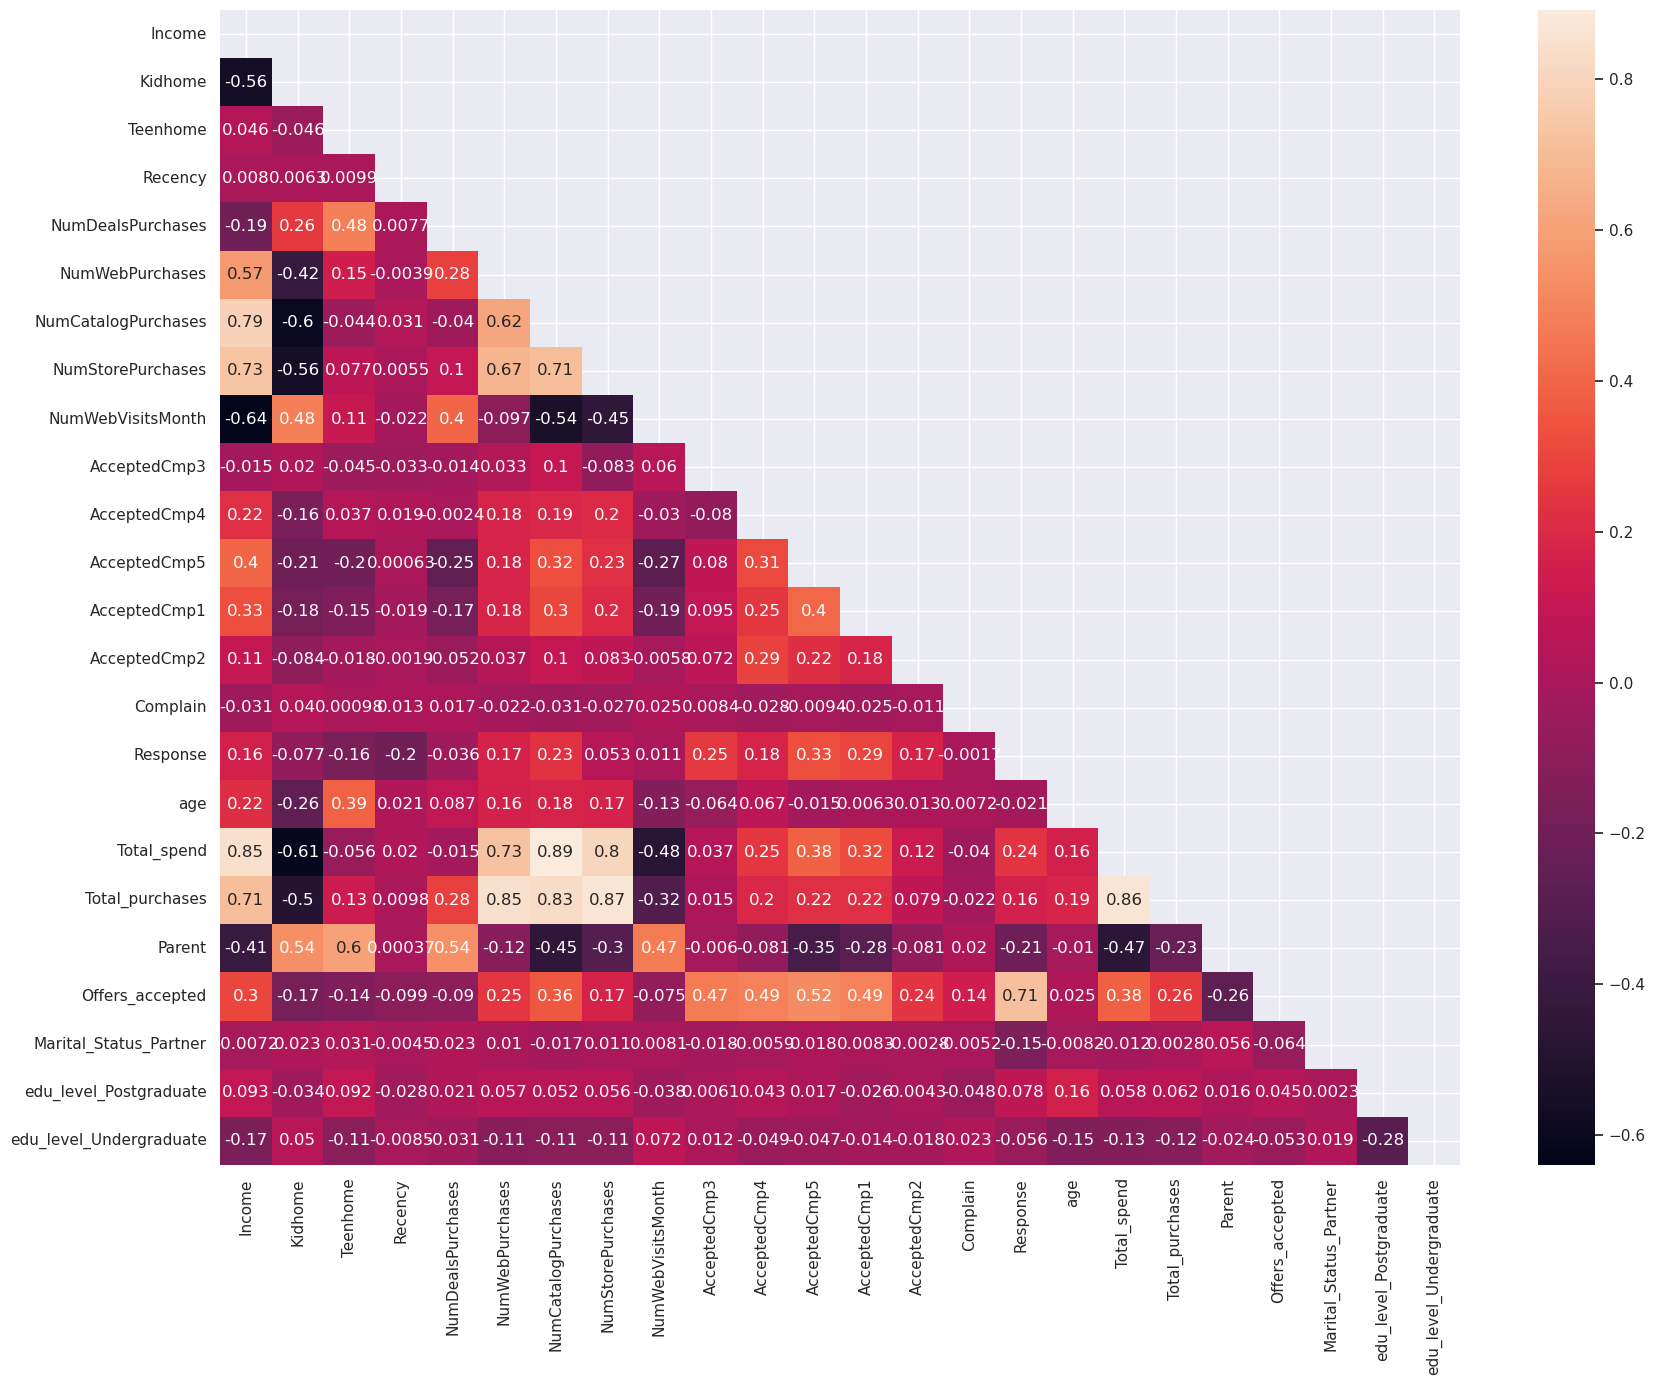

In [68]:
plt.figure(figsize=(20,15))
mask = np.triu(processed_df.corr(method='spearman'))
sns.heatmap(processed_df.corr(method='spearman'), annot=True, mask=mask)
plt.show()

In [69]:
processed_df.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'age',
       'Total_spend', 'Total_purchases', 'Parent', 'Offers_accepted',
       'Marital_Status_Partner', 'edu_level_Postgraduate',
       'edu_level_Undergraduate'],
      dtype='object')

In [70]:
processed_df_cl = processed_df.drop(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Response'], axis=1)

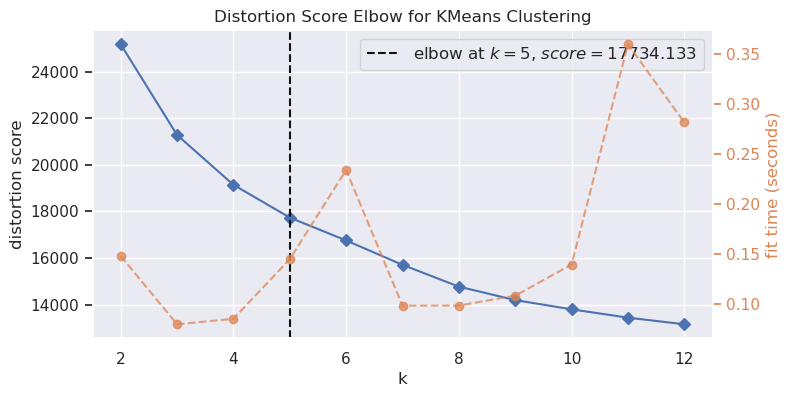

In [71]:
def plot_elbow_curve(data, k):
    plt.figure(figsize=(8,4))
    model = KMeans(init='k-means++')
    elbow_visualizer = KElbowVisualizer(model, k=k)
    elbow_visualizer.fit(data)
    elbow_visualizer.show()
    global elbow_val
    elbow_val = elbow_visualizer.elbow_value_

plot_elbow_curve(processed_df_cl, k=12)


In [72]:
pca = PCA(n_components=3)
pca_df = pca.fit_transform(processed_df_cl)

In [73]:
kmeans = KMeans(n_clusters=elbow_val, init='k-means++')

In [74]:
kmeans.fit(pca_df)

KMeans(n_clusters=5)

In [75]:
kmeans.inertia_

4896.1936664885525

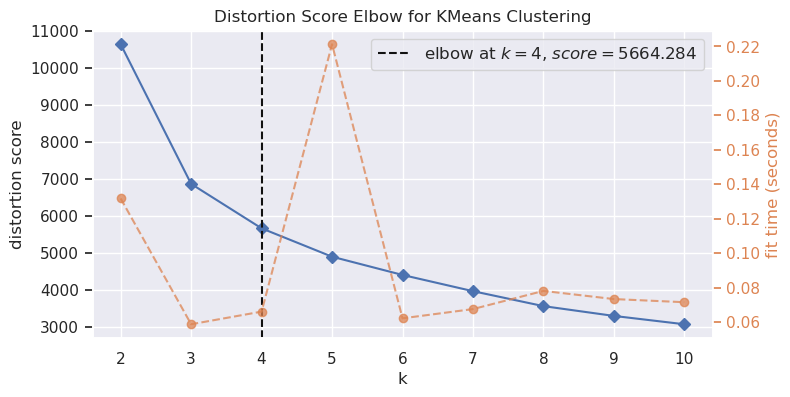

In [76]:
def plot_elbow_curve(data, k):
    plt.figure(figsize=(8,4))
    model = KMeans(init='k-means++')
    elbow_visualizer = KElbowVisualizer(model, k=k)
    elbow_visualizer.fit(data)
    elbow_visualizer.show()
    global elbow_val
    elbow_val = elbow_visualizer.elbow_value_

plot_elbow_curve(pca_df, k=10)


In [77]:
pred = kmeans.predict(pca_df)

In [78]:
pred

array([2, 3, 2, ..., 2, 1, 3], dtype=int32)

In [79]:
px.scatter(pca_df, x = pca_df[:, 0], y = pca_df[:, 1],color=pred )

In [80]:
fig = px.scatter_3d(pca_df, x=pca_df[:, 0], y=pca_df[:, 1], z=pca_df[:, 2], color=pred, width=700)
fig.show()

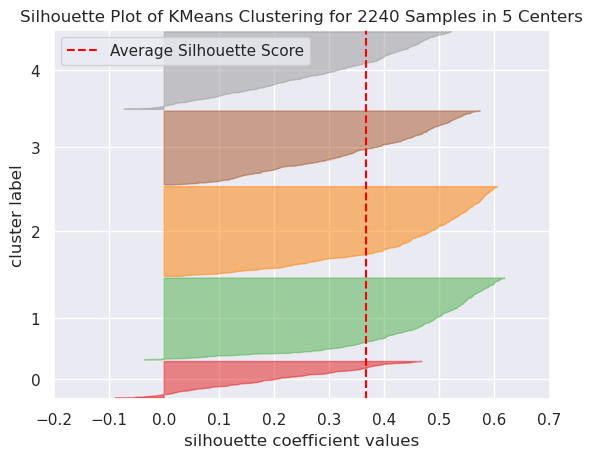

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2240 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [81]:
model_5clust = KMeans(n_clusters = 5, random_state=9)

sil_visualizer = SilhouetteVisualizer(model_5clust)
sil_visualizer.fit(pca_df)    
sil_visualizer.show()

In [82]:
list_k = list(range(2, 10))
silhouette_scores = []
for k in list_k:
    km = KMeans(n_clusters=k)
    preds = km.fit_predict(pca_df)
    silhouette_scores.append(silhouette_score(pca_df, preds))

print('Best k:',best_k:=list_k[np.argmax(silhouette_scores)])

display('Silhouette Scores:',silhouette_scores)

Best k: 3


'Silhouette Scores:'

[0.4260296136961485,
 0.44238189764322006,
 0.37599074171809416,
 0.36700017614016733,
 0.3313581546494608,
 0.31637033024436995,
 0.3255051156369602,
 0.3254910182945264]

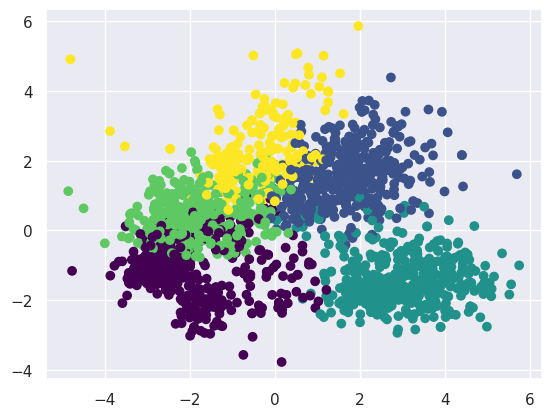

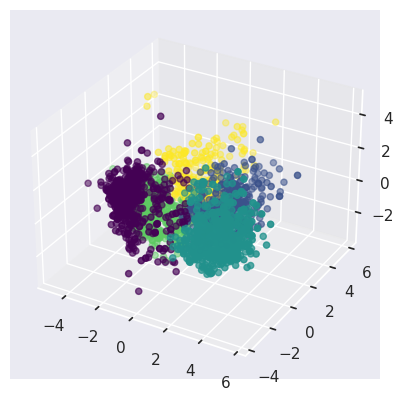

Silhouette Score: 0.3390767477277274


In [83]:
X = pca_df

# Compute distance matric
dist_matrix = squareform(pdist(X))

agg_cluster = AgglomerativeClustering(n_clusters=5)
culsters_pred_agg = agg_cluster.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=agg_cluster.labels_, cmap='viridis')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=agg_cluster.labels_, cmap='viridis')
plt.show()

silhouette_score_value = silhouette_score(X, agg_cluster.labels_)

print("Silhouette Score:", silhouette_score_value)

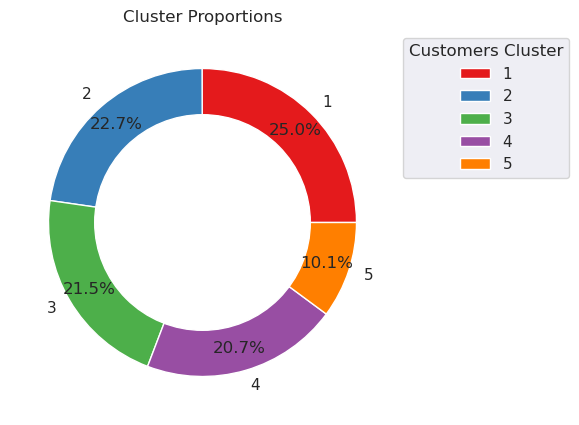

In [84]:
pred = kmeans.predict(pca_df)
clusters = processed_df.copy()
clusters['Cluster'] = pred + 1

cluster_size = dict(clusters['Cluster'].value_counts())

plt.figure(figsize=(5, 5))
plt.title("Cluster Proportions")
plt.pie(cluster_size.values(), labels=sorted(cluster_size.keys()), 
        autopct="%.1f%%", pctdistance=0.85,colors=sns.color_palette("Set1"))
plt.legend(title="Customers Cluster", labels=sorted(cluster_size.keys()), bbox_to_anchor=(1, 1))

donut = plt.Circle((0,0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(donut)
plt.show()

In [85]:
#inverse transform to interpret the values
inverse_transformed_num = pipeline.named_transformers_['numerical_transformer']['scaling'].inverse_transform(processed_df[num_cols])
inversed_df = clusters.copy()
# Replace the transformed numerical columns with the inverse transformed values
inversed_df[num_cols] = inverse_transformed_num

inverse_transformed_cat = pipeline.named_transformers_['categorical_transformer']['encoding'].inverse_transform(processed_df[cat_cols_enc])
inversed_df[cat_cols] = inverse_transformed_cat

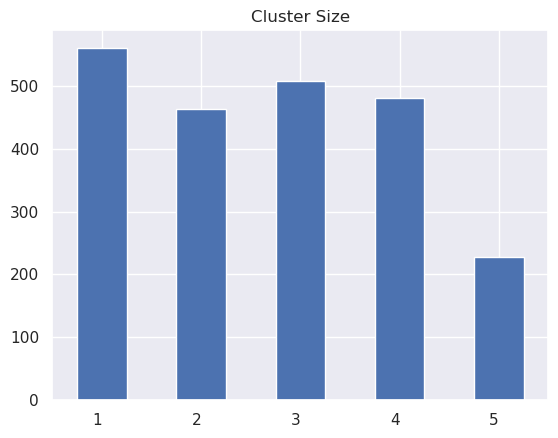

In [86]:
ax = inversed_df['Cluster'].value_counts().sort_index().plot(kind='bar', rot=90)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')
ax.set_title('Cluster Size')
plt.show()

In [87]:
px.box(inversed_df, x='Cluster', y='Income')

- Cluster 1 is the high income group followed by the Cluster 3

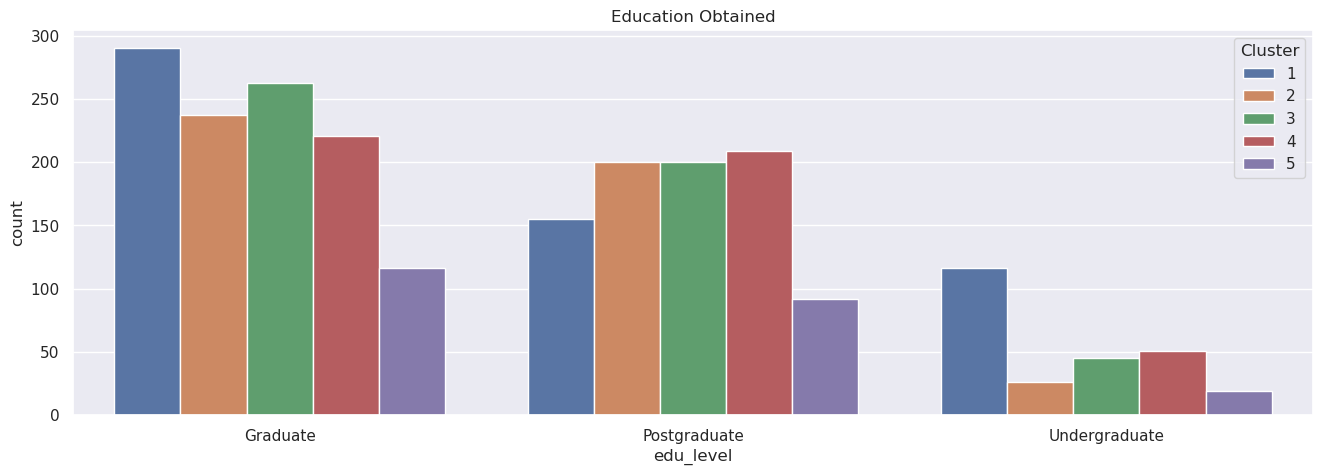

In [88]:
plt.figure(figsize=(16,5))
plt.title(f'Education Obtained')
sns.countplot(data=inversed_df, x='edu_level', hue='Cluster')
plt.show()

- Undergraduates are more in Cluster 2
- Postgraduates are more in Cluster 5
- Graduates are more in Cluster 2

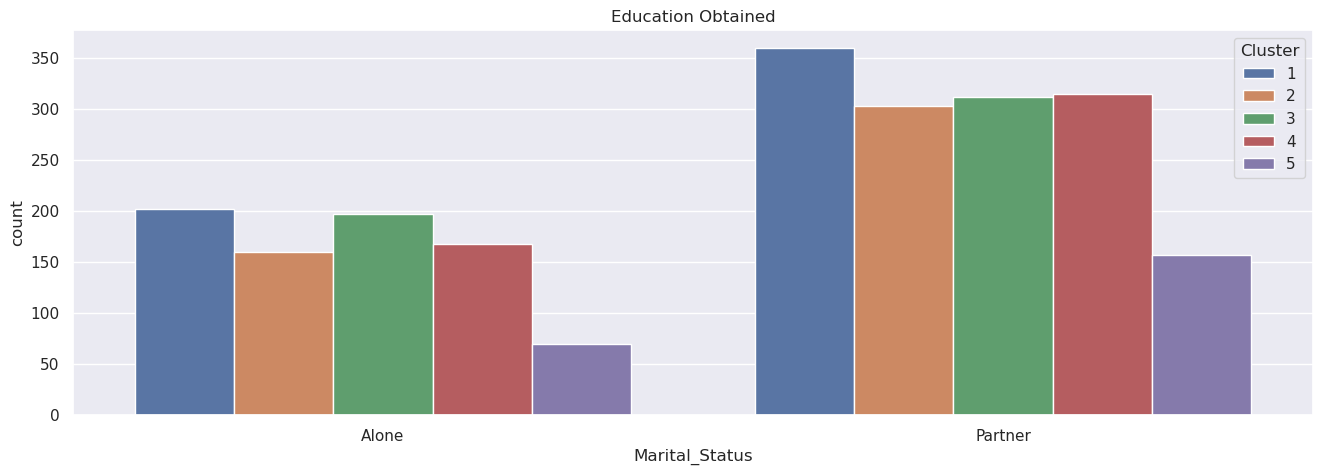

In [89]:
plt.figure(figsize=(16,5))
plt.title(f'Education Obtained')
sns.countplot(data=inversed_df, x='Marital_Status', hue='Cluster')
plt.show()

In [90]:
inversed_df

Income  Kidhome  Teenhome  Recency  NumDealsPurchases  NumWebPurchases  \
0     58138.0      0.0       0.0     58.0                3.0              8.0   
1     46344.0      1.0       1.0     38.0                2.0              1.0   
2     71613.0      0.0       0.0     26.0                1.0              8.0   
3     26646.0      1.0       0.0     26.0                2.0              2.0   
4     58293.0      1.0       0.0     94.0                5.0              5.0   
...       ...      ...       ...      ...                ...              ...   
2235  61223.0      0.0       1.0     46.0                2.0              9.0   
2236  64014.0      2.0       1.0     56.0                7.0              8.0   
2237  56981.0      0.0       0.0     91.0                1.0              2.0   
2238  69245.0      0.0       1.0      8.0                2.0              6.0   
2239  52869.0      1.0       1.0     40.0                3.0              3.0   

      NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                    10.0                4.0                7.0           0.0   
1                     1.0                2.0                5.0           0.0   
2                     2.0               10.0                4.0           0.0   
3                     0.0                4.0                6.0           0.0   
4                     3.0                6.0                5.0           0.0   
...                   ...                ...                ...           ...   
2235                  3.0                4.0                5.0           0.0   
2236                  2.0                5.0                7.0           0.0   
2237                  3.0               13.0                6.0           0.0   
2238                  5.0               10.0                3.0           0.0   
2239                  1.0                4.0                7.0           0.0   

      AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0              0.0           0.0           0.0           0.0       0.0   
1              0.0           0.0           0.0           0.0       0.0   
2              0.0           0.0           0.0           0.0       0.0   
3              0.0           0.0           0.0           0.0       0.0   
4              0.0           0.0           0.0           0.0       0.0   
...            ...           ...           ...           ...       ...   
2235           0.0           0.0           0.0           0.0       0.0   
2236           0.0           0.0           1.0           0.0       0.0   
2237           1.0           0.0           0.0           0.0       0.0   
2238           0.0           0.0           0.0           0.0       0.0   
2239           0.0           0.0           0.0           0.0       0.0   

      Response   age  Total_spend  Total_purchases  Parent  Offers_accepted  \
0          1.0  66.0       1617.0             25.0     0.0     1.000000e+00   
1          0.0  69.0         27.0              6.0     1.0     5.551115e-17   
2          0.0  58.0        776.0             21.0     0.0     5.551115e-17   
3          0.0  39.0         53.0              8.0     1.0     5.551115e-17   
4          0.0  42.0        422.0             19.0     1.0     5.551115e-17   
...        ...   ...          ...              ...     ...              ...   
2235       0.0  56.0       1341.0             18.0     1.0     5.551115e-17   
2236       0.0  77.0        444.0             22.0     1.0     1.000000e+00   
2237       0.0  42.0       1241.0             19.0     0.0     1.000000e+00   
2238       0.0  67.0        843.0             23.0     1.0     5.551115e-17   
2239       1.0  69.0        172.0             11.0     1.0     1.000000e+00   

      Marital_Status_Partner  edu_level_Postgraduate  edu_level_Undergraduate  \
0                        0.0                     0.0                      0.0   
1                        0.0                     0.0         

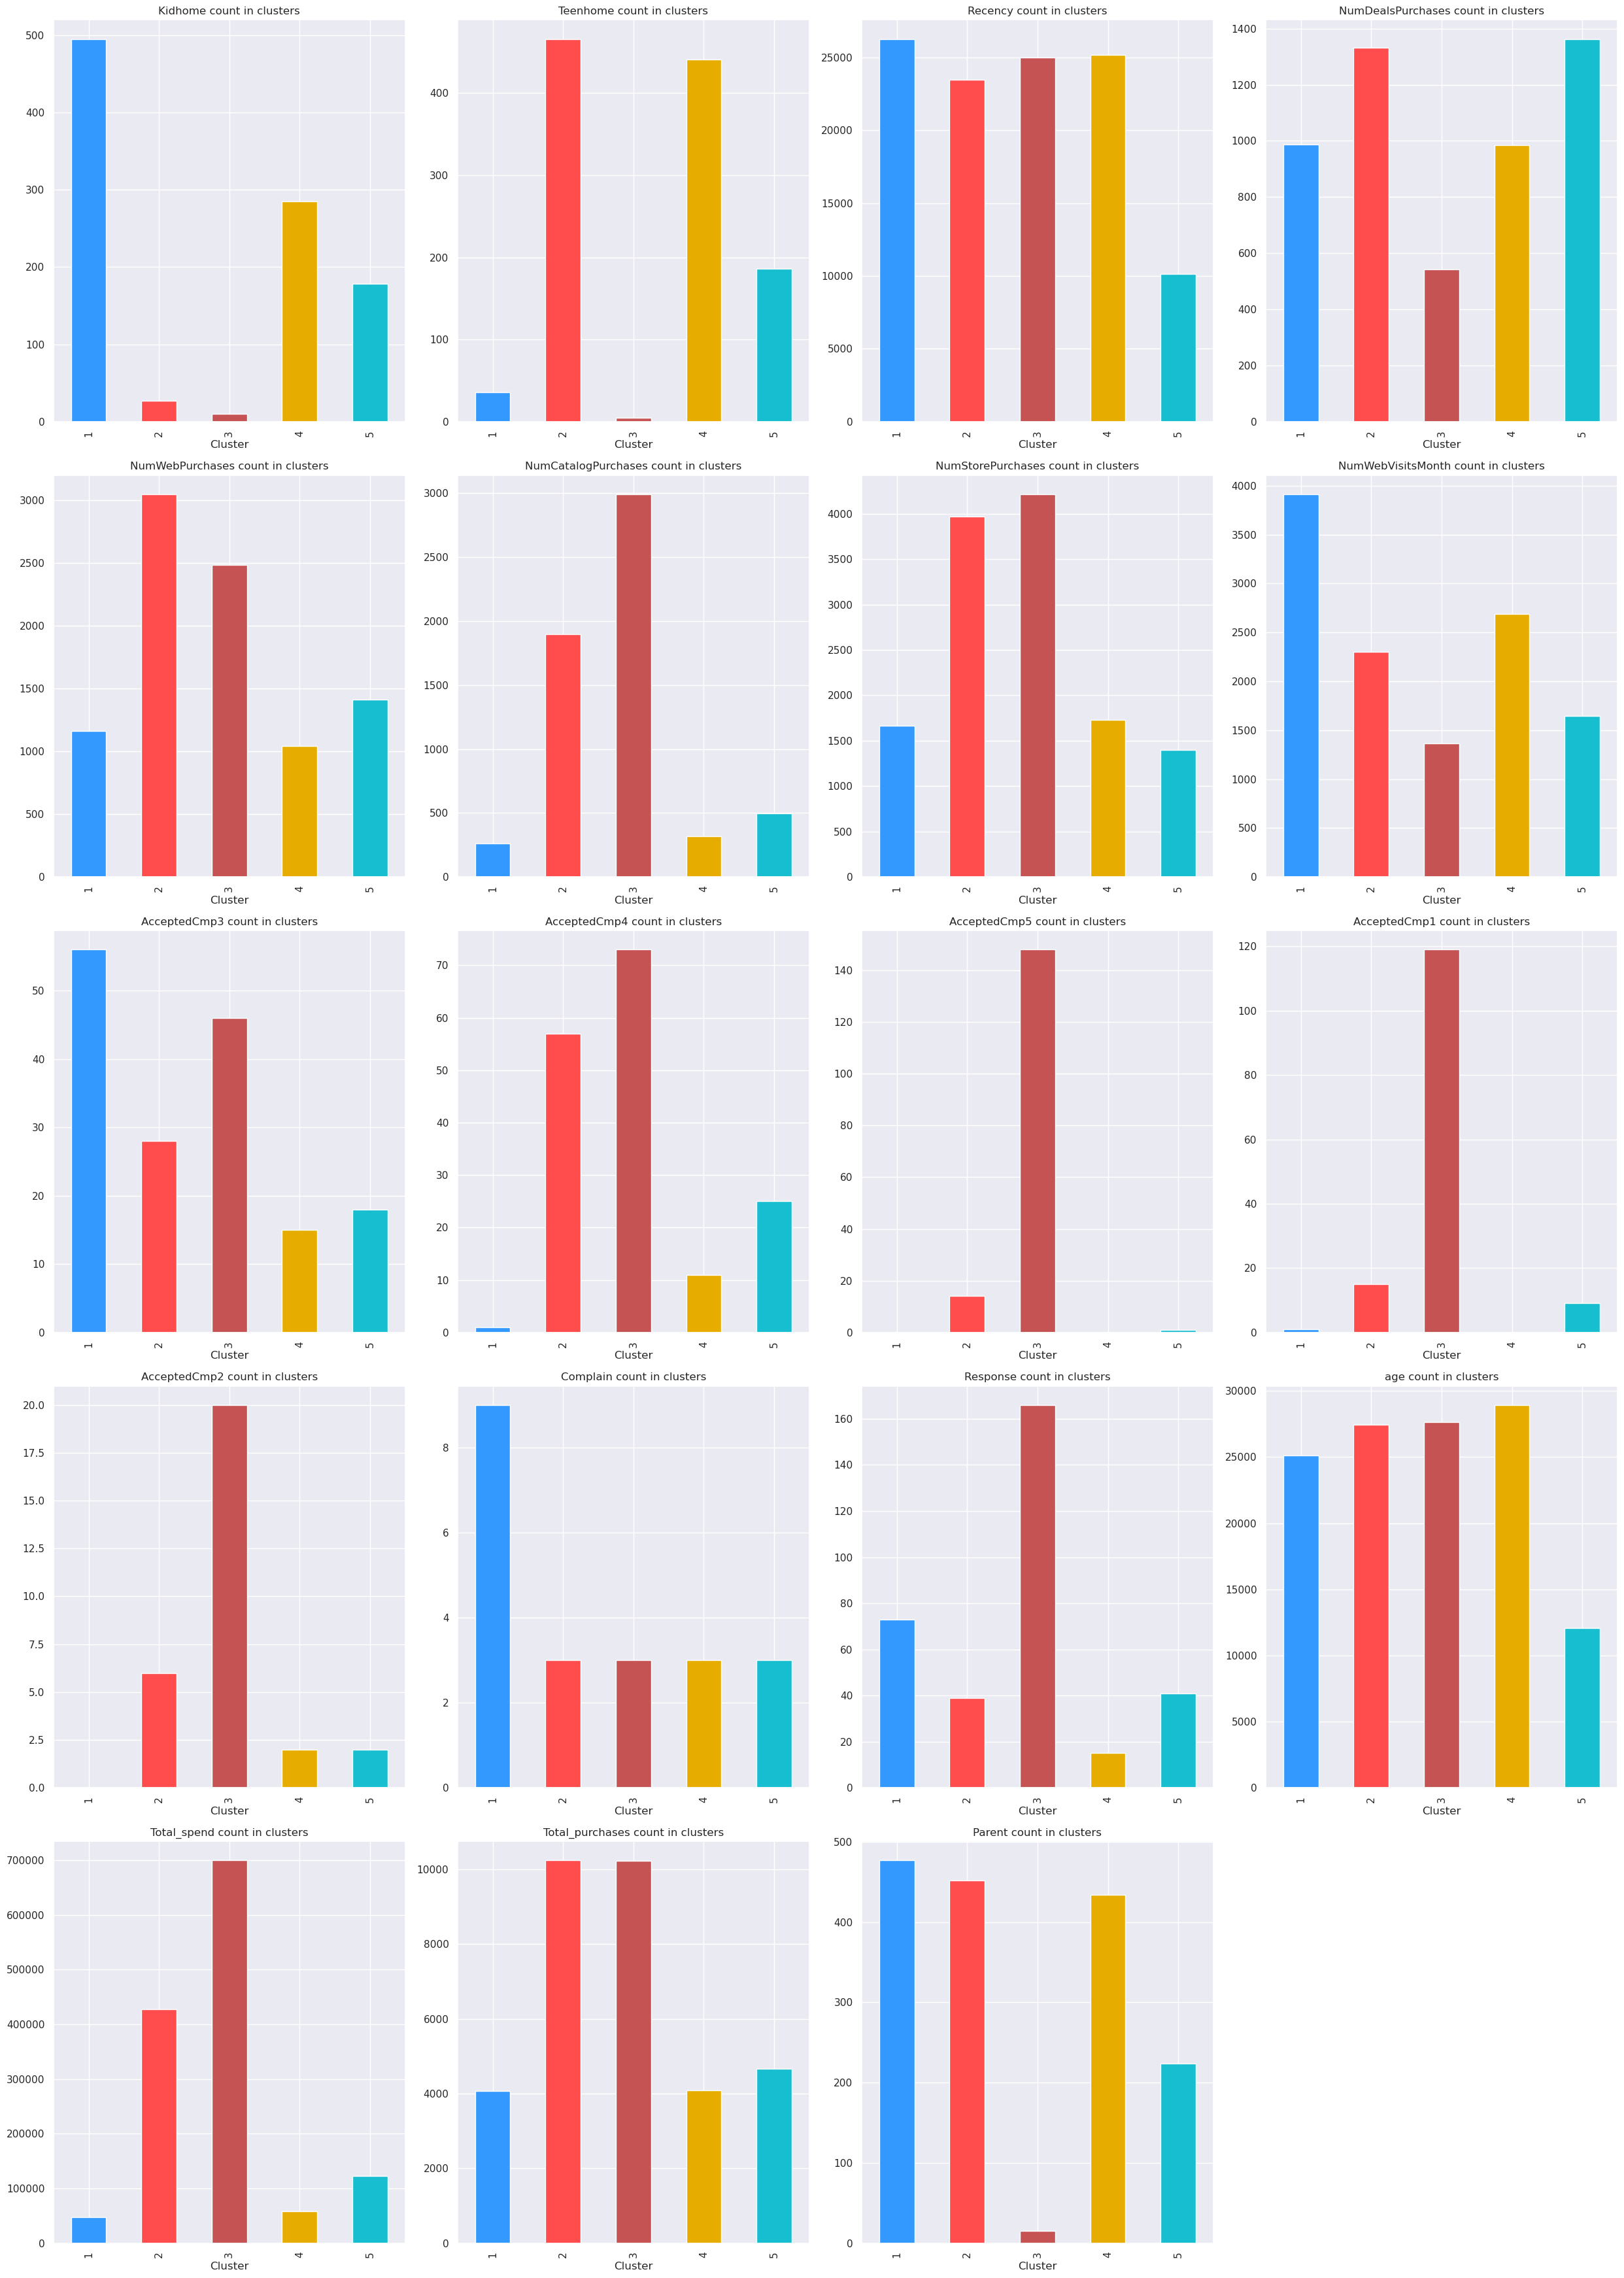

In [91]:
cols = ['Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
        'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
        'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'age',
        'Total_spend', 'Total_purchases', 'Parent']

custom_colors = ['#3399ff', '#ff4d4d', '#c65353', '#e6ac00', '#17becf']

plt.figure(figsize=(25, 35))
for i, col in enumerate(cols, 1):
    plt.subplot(5, 4, i)
    inversed_df.groupby('Cluster')[col].sum().plot(kind='bar', color=custom_colors)
    plt.title('{} count in clusters'.format(col))

plt.tight_layout()
plt.show()

## Modelling 

In [93]:
model_df = inversed_df.copy()
model_df.drop(['Offers_accepted', 'Cluster', 'Marital_Status', 'edu_level'], axis=1, inplace=True)

X = model_df.drop('Response', axis=1)
y = model_df.Response

In [94]:
#checking important feature with mrmr
from mrmr import mrmr_classif
mrmr_classif(X, y, K=19)

100%|███████████████████████████████████████████████████| 19/19 [00:00<00:00, 41.05it/s]


['AcceptedCmp5',
 'Recency',
 'Marital_Status_Partner',
 'AcceptedCmp3',
 'AcceptedCmp1',
 'Total_spend',
 'AcceptedCmp2',
 'edu_level_Postgraduate',
 'Teenhome',
 'NumCatalogPurchases',
 'AcceptedCmp4',
 'Parent',
 'NumWebPurchases',
 'Income',
 'Total_purchases',
 'edu_level_Undergraduate',
 'Kidhome',
 'NumStorePurchases',
 'age']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
xg = XGBClassifier()

xg.fit(X_train, y_train)

y_pred_test = xg.predict(X_test)
y_pred_train = xg.predict(X_train)

train_sc = accuracy_score(y_train, y_pred_train)
test_sc = accuracy_score(y_test, y_pred_test)
cvs = cross_val_score(xg, X, y, cv=5)

print('Train score:',train_sc)
print('Test score:',test_sc)
print('CVS:',cvs.mean())

Train score: 0.9905133928571429
Test score: 0.8973214285714286
CVS: 0.8852678571428572


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

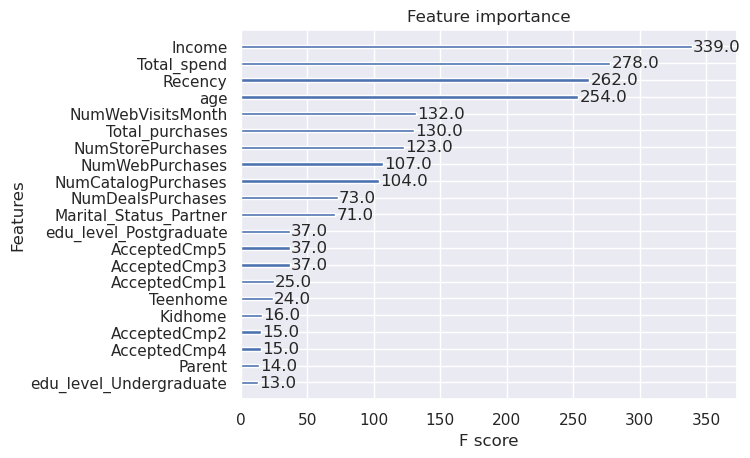

In [96]:
plot_importance(xg)

In [97]:
estimator = XGBClassifier()
param_grid = {'n_estimators':[10,20,30,40,50], 'learning_rate':[0.01,0.001,0.0001],
             'gamma':[0,0.3,0.5,0.7,1], 'max_depth':[3,5,7]}

model_hp = GridSearchCV(estimator, param_grid, cv=5, scoring='accuracy')
model_hp.fit(X_train, y_train)

print(model_hp.best_params_,model_hp.best_estimator_, sep='\n')

{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 40}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=40, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [98]:
xg = XGBClassifier(gamma = 1, learning_rate =0.01, max_depth = 5, n_estimators = 30)

xg.fit(X_train, y_train)

y_pred_test = xg.predict(X_test)
y_pred_train = xg.predict(X_train)

train_sc = accuracy_score(y_train, y_pred_train)
test_sc = accuracy_score(y_test, y_pred_test)
cvs = cross_val_score(xg, X, y, cv=5)

print('Train score:',train_sc)
print('Test score:',test_sc)
print('CVS:',cvs.mean())

Train score: 0.9045758928571429
Test score: 0.890625
CVS: 0.8785714285714284


In [99]:
confusion_matrix(y_test, y_pred_test)

array([[367,  11],
       [ 38,  32]])

In [100]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X, y = smote.fit_resample(X,y)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
xg = XGBClassifier()

xg.fit(X_train, y_train)

y_pred_test = xg.predict(X_test)
y_pred_train = xg.predict(X_train)

train_sc = accuracy_score(y_train, y_pred_train)
test_sc = accuracy_score(y_test, y_pred_test)
cvs = cross_val_score(xg, X, y, cv=5)

print('Train score:',train_sc)
print('Test score:',test_sc)
print('CVS:',cvs.mean())

Train score: 0.9954083306001967
Test score: 0.9370904325032765
CVS: 0.9150466283457688


In [102]:
estimator = XGBClassifier()
param_grid = {'n_estimators':[10,20,30,40,50], 'learning_rate':[0.01,0.001,0.0001],
             'gamma':[0,0.3,0.5,0.7,1], 'max_depth':[3,5,7]}

model_hp = GridSearchCV(estimator, param_grid, cv=5, scoring='accuracy')
model_hp.fit(X_train, y_train)

print(model_hp.best_params_,model_hp.best_estimator_, sep='\n')

{'gamma': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.7, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [103]:
xg = XGBClassifier(gamma = 1, learning_rate =0.01, max_depth = 7, n_estimators = 50)

xg.fit(X_train, y_train)

y_pred_test = xg.predict(X_test)
y_pred_train = xg.predict(X_train)

train_sc = accuracy_score(y_train, y_pred_train)
test_sc = accuracy_score(y_test, y_pred_test)
cvs = cross_val_score(xg, X, y, cv=5)

print('Train score:',train_sc)
print('Test score:',test_sc)
print('CVS:',cvs.mean())

Train score: 0.9360446047884552
Test score: 0.90956749672346
CVS: 0.8804150627960496


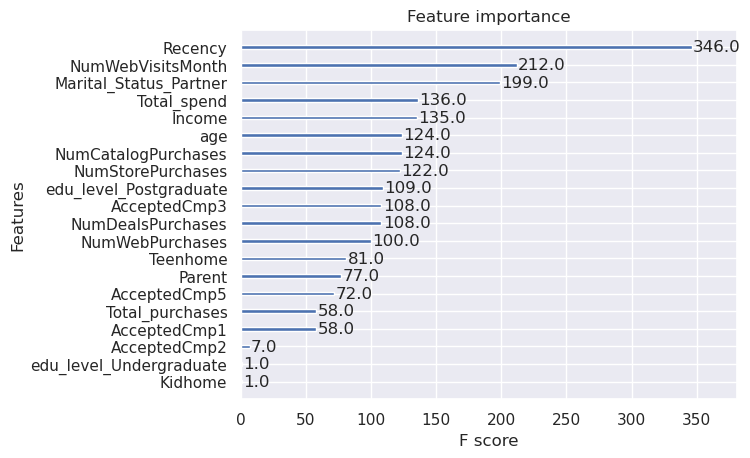

In [104]:
plot_importance(xg)
plt.show()